# 0.0 General Area

## 0.1 Import Libraries

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

import math 
import inflection
import datetime
import pickle
import warnings
import random
import json
import requests


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy

from scipy                 import stats as ss

warnings.filterwarnings( 'ignore' )

## 0.2 Support Functions

In [2]:
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    return df

def numerical_attributes( df ):
    # Central Tendency - mean, median
    df_mean   = pd.DataFrame( df.apply( np.mean ) ).T
    df_median = pd.DataFrame( df.apply( np.median ) ).T

    # Dispersion - min, max, range, std, skew, kurtosis
    df_min =      pd.DataFrame( df.apply( np.min ) ).T
    df_max =      pd.DataFrame( df.apply( np.max ) ).T
    df_range =    pd.DataFrame( df.apply( lambda x: x.max() - x.min() ) ).T
    df_std =      pd.DataFrame( df.apply( np.std ) ).T
    df_skew =     pd.DataFrame( df.apply( lambda x: x.skew() ) ).T
    df_kurtosis = pd.DataFrame( df.apply( lambda x: x.kurtosis() ) ).T

    # concatenate dataframes
    df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
    df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

    return df_numerical

def categorical_attributes( df ):
    for column in df.columns:
        print( df[column].value_counts( normalize=True ) )
        print('===========================\n' )

    return None

def fillout_na( df ):
    # competition_distance with NA values means "no competitor around". Set max value = 200000
    max_value = df['competition_distance'].max()
    df['competition_distance'] = df['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

    # competition_open_since_month and competition_open_since_year 
    # Set month and year of sale as default value
    df['competition_open_since_month'] = df.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    df['competition_open_since_year']  = df.apply( lambda x: x['date'].year if math.isnan(  x['competition_open_since_year'] )  else x['competition_open_since_year'], axis=1 )

    # promo2_since_week  and promo2_since_year
    # Set month and year of sale as default value
    df['promo2_since_week'] = df.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
    df['promo2_since_year'] = df.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    # promo_interval  - first, create a new column(month_map) with the month of sale  
    month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
    df['promo_interval'].fillna( 0, inplace=True )
    df['month_map'] = df['date'].dt.month.map( month_map )

    # promo_inteval - second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
    df['is_promo'] = df[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 

    return df

def change_data_types( df ):   
    df['competition_open_since_month']  = df['competition_open_since_month'].astype( int )
    df['competition_open_since_year']   = df['competition_open_since_year'].astype( int )
    df['promo2_since_week']             = df['promo2_since_week'].astype( int )
    df['promo2_since_year']             = df['promo2_since_year'].astype( int )

    return df 


def data_cleaning( df ):

    df = rename_columns( df )
    df = fillout_na( df )
    df = change_data_types( df )

    return df


def create_features( df ):
    # year
    df['year'] = df['date'].dt.year

    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

    # year week
    df['year_week'] = df.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

    # from competition_open_since columns
    df['competition_since']      = df.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
    df['competition_time_month'] = df.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

    # from promo2_since
    df['promo2_since']     = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
    df['promo2_since']     = df['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df['promo2_time_week'] = df.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

    #  describes an assortment level: a = basic, b = extra, c = extended
    df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

    # Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
    # a = public holiday, b = easter holiday, c = christmas, 0 = regular day
    df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

    return df

def remove_rows( df ):
    # remove lines where there are no sales
    df = df[ ( df['open'] != 0 ) & ( df['sales'] > 0 ) ]

    return df

def drop_cols( df ):
    cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
    df = df.drop( cols_drop, axis=1 )

    return df

def feature_engineering( df ):
    df = create_features( df )
    df = remove_rows( df )
    df = drop_cols( df )

    return df

def rescaling_features( df, train=True ):
    # Apply MinMaxScaler - promo2_time_week
    mms = MinMaxScaler()
    df['promo2_time_week'] = mms.fit_transform( df[['promo2_time_week']].values )
    if train:
        pickle.dump( mms, open( '../parameters/promo2_time_week_scaler.pkl', 'wb' ) )

    # Apply MinMaxScaler - year
    mms = MinMaxScaler()
    df['year'] = mms.fit_transform( df[['year']].values )
    if train:
        pickle.dump( mms, open( '../parameters/year_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_distance
    rs = RobustScaler()
    df['competition_distance'] = rs.fit_transform( df[['competition_distance']].values )
    if train:    
        pickle.dump( rs, open( '../parameters/competition_distance_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_time_month
    rs = RobustScaler()
    df['competition_time_month'] = rs.fit_transform( df[['competition_time_month']].values )
    if train:
        pickle.dump( rs, open( '../parameters/competition_time_month_scaler.pkl', 'wb' ) )

    return df 

def encoding_features( df, train=True ):
    # Apply One-Hot Encoding - state_holiday
    df = pd.get_dummies( df, prefix=['state_holiday'], columns=['state_holiday'] )     

    # Apply Label Encoding - store_type
    le = LabelEncoder()
    df['store_type'] = le.fit_transform( df['store_type'])
    if train:
        pickle.dump( le, open( '../parameters/store_type_scaler.pkl', 'wb' ) )       

    # Apply Ordinal Encoding - assortment
    assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
    df['assortment'] = df['assortment'].map( assortment_dict )

    return df

def magnitude_features( df ):
    # Apply Logarithm Transformation - response variable (sales)
    df['sales'] = np.log1p( df['sales'] ) 

    return df

def ciclyc_features( df ):
    # Calculate sin and cos - month - variable with cyclic behavior
    df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
    df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

    # Calculate sin and cos - day_of_week - variable with cyclic behavior
    df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
    df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

    # Calculate sin and cos - day - variable with cyclic behavior
    df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
    df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

    # Calculate sin and cos - week_of_year - variable with cyclic behavior
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

    return df


def data_preparation( df, df_type ):

    # apply rescaling methods 
    df = rescaling_features( df, df_type )   

    # apply enconding methods to categorical features
    df = encoding_features( df, df_type )

    # change features magnitude
    df = magnitude_features( df )

    # apply method to features with cyclical behavior
    df = ciclyc_features( df )

    return df


# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

#def mean_absolute_percentage_error( y, yhat ):
#    return np.round( np.mean( np.abs( ( y - yhat ) / y ) ) * 100, 2 )

def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list =  []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date   = x_training['date'].max() - datetime.timedelta( days=( k-1 )*6*7 )
                                                                            
        # filtering dataset
        training   = x_training[ x_training['date'] <= validation_start_date]
        validation = x_training[ (x_training['date'] > validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

        # verbose
        if verbose:
            print(f'Fold:{k}. Period: {validation_start_date} - {validation_end_date} ')

    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE'  : np.round( np.mean( mae_list ),  2 ),
                            'MAPE' : np.round( np.mean( mape_list ), 2 ),
                            'RMSE' : np.round( np.mean( rmse_list ), 2 )
                        }, index=[0] )

    #return pd.DataFrame( {  'Model Name': model_name,
    #                        'MAE'  : np.round( np.mean( mae_list ),  2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
    #                        'MAPE' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
    #                        'RMSE' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )
    #                    }, index=[0] )

def get_model_prediction( test_file, local=True ):
    x_test = pd.read_csv( test_file,  low_memory= False )

    # remove close day
    x_test = x_test[ ( x_test['open'] != 0 ) ]

    y_test = x_test['sales'].values
    x_test = x_test.drop( columns=['sales'], axis=1 )

    # convert dataframe to json
    json_data = json.dumps( x_test.to_dict( orient='records' ) )

    # API CALL

    if local:
        # local request
        url = 'http://0.0.0.0:5000/rossmann/predict'
    else:
        # Render´s Server request
        url = 'https://rossmann-app-9l04.onrender.com/rossmann/predict'
        
   
    header = { 'Content-type' : 'application/json' }
    response = requests.post( url, data=json_data, headers=header )

    check_status = response.status_code

    if check_status == 200:
        
        # return dataframe with predictions
        df = pd.DataFrame( response.json(), columns=response.json()[0].keys() )
        df = df[['store', 'date', 'sales_predictions']]

        df['sales']          = y_test
        df['absolute_error'] = np.abs( y_test - df['sales_predictions'].values )

        return df
    
    else:
        return pd.DataFrame()


def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

## 0.3 Load Data

In [3]:
# reading data
df_train_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store.csv', low_memory= False )

# merging datasets train and store
df_raw = pd.merge( df_train_raw, df_store_raw, how='left', on='Store')
df_raw.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 0.4 Rename Columns

In [4]:
df_raw = rename_columns( df_raw )
df_raw.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [6]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 1017209
Number of Cols: 18


## 1.2 List Data Types

In [7]:
# list data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

**Considerações**
- Campo "date" é do tipo object, ele representa a data da venda e deve ser convertido para datetime

## 1.3 Check NA

In [8]:
# number of rows with NA values by column
df1.isna().sum() / len( df1 )

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

**Considerações**
- Campo "competition_distance" possui um pequeno número de linhas com nulos. Verificar melhor método de preenchimento
- Campos envolvendo dados de "competições" e "promoções" com alto percentual de nulos. Verificar como preenchê-los

## 1.4 Descriptive Statistical

In [9]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.4.1 Numerical Attributes

In [10]:
numerical_attributes( df_num_attributes )

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5430.085652,NaN,7715.319898,2.928534,13.000022
8,competition_open_since_month,1.0,12.0,11.0,7.222866,NaN,3.211830,-0.169862,-1.248357
9,competition_open_since_year,1900.0,2015.0,115.0,2008.690228,NaN,5.992640,-7.539515,121.934675


**Considerações**
- Campos "open", "sales" e "customers" com valores zerados indicam que há dias sem vendas. Provável remoção de linhas

### 1.4.2 Categorical Attributes

In [11]:
categorical_attributes( df_cat_attributes.drop( columns=['date'], axis=1 ) )

state_holiday
0    0.969475
a    0.019917
b    0.006577
c    0.004031
Name: proportion, dtype: float64

store_type
a    0.542295
d    0.307618
c    0.134525
b    0.015562
Name: proportion, dtype: float64

assortment
a    0.528353
c    0.463494
b    0.008154
Name: proportion, dtype: float64

promo_interval
Jan,Apr,Jul,Oct     0.575677
Feb,May,Aug,Nov     0.232917
Mar,Jun,Sept,Dec    0.191407
Name: proportion, dtype: float64



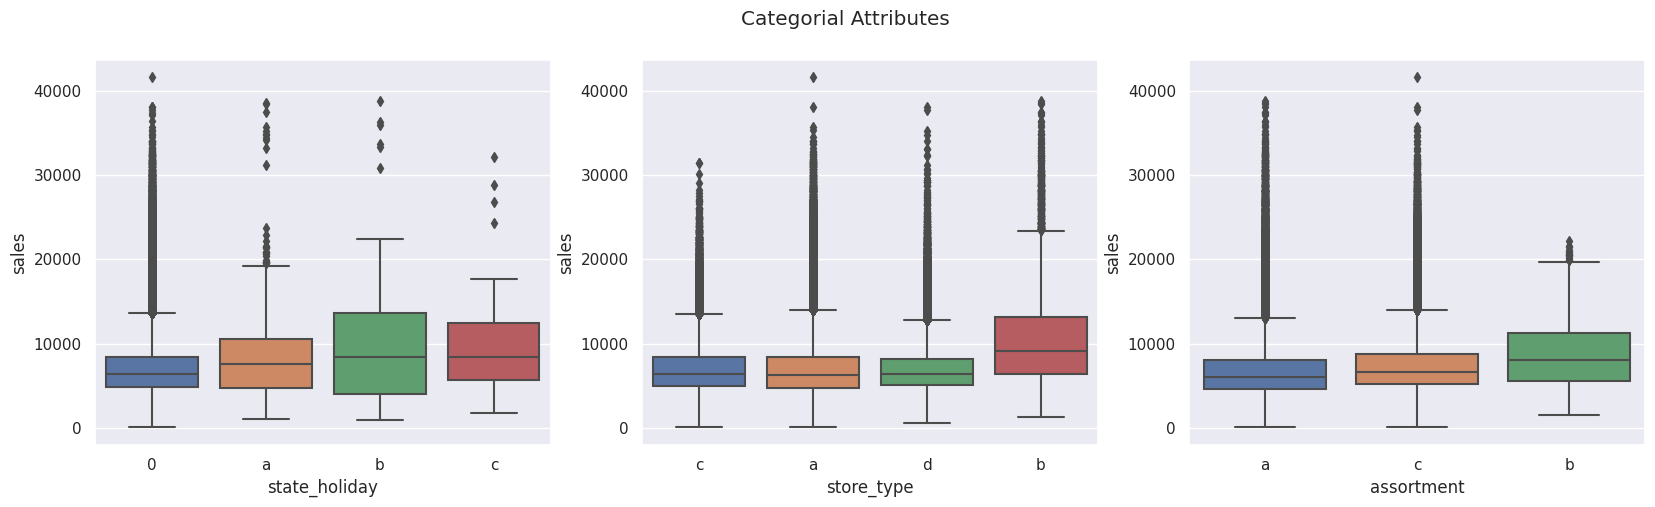

In [12]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.boxplot( ax=axes[0], x='state_holiday', y='sales', data=df1_aux );
sns.boxplot( ax=axes[1], x='store_type',    y='sales', data=df1_aux );
sns.boxplot( ax=axes[2], x='assortment',    y='sales', data=df1_aux );


**Observações**
- O campo "state_holiday" apresenta alta concentração em uma classe, que faz sentido por se tratar de indicações de determinados feriados.
- Os campos "store_type" e "assortment" possuem, cada, uma classe com baixa concentração.

# 2.0 Data Cleaning

In [13]:
df2 = df1.copy()

## 2.1 Convert feature "date" before fillout NA

In [14]:
# change type of column "date"
df2['date'] = pd.to_datetime( df2['date'] ) 

**Considerações**
- O campo "date" foi convertido em datetime para que possa servir de base para o preenchimento de outros campos no passo seguinte

## 2.2 Fillout NA

In [15]:
df2 = fillout_na( df2 )
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.3 Change Data Types

In [16]:
df2 = change_data_types( df2 )
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.4 Remove Rows

In [17]:
rows_before = df2.shape[0]
df2 = remove_rows( df2 )

print(f'Prior Number of rows: { rows_before } ' )
print(f'New   Number of rows: { df2.shape[0] } ' )

print(f'Total rows removed  : { rows_before - df2.shape[0] } ' )
print(f'Removal Percentage  : { round( ( rows_before - df2.shape[0] ) / rows_before * 100, 2 ) } %' )

Prior Number of rows: 1017209 
New   Number of rows: 844338 
Total rows removed  : 172871 
Removal Percentage  : 16.99 %


# 3.0 Feature Engineering

In [18]:
df3 = df2.copy()

## 3.1 Hypothesis Mind Map

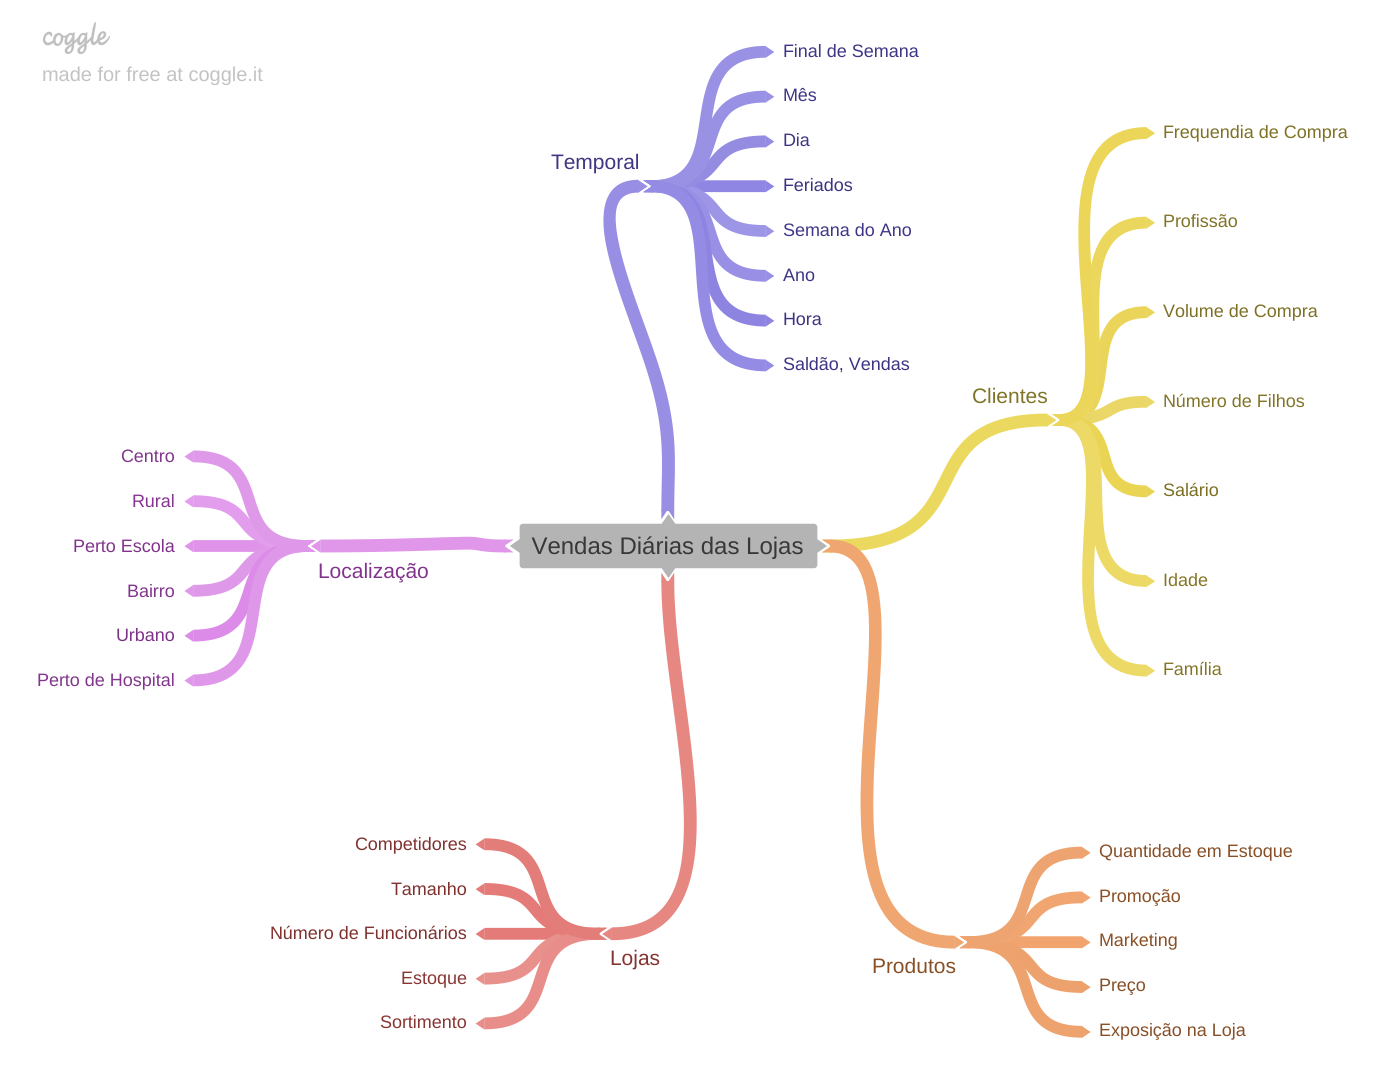

In [19]:
Image( '../img/mapa_de_hipoteses.png')

## 3.2 List of Hypotheses

### 3.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 3.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 3.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 3.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 3.4 Create Features

In [20]:
df3 = create_features( df3 )

### 3.4.1 From date column

In [21]:
df3[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
60143,2015-06-08,2015,6,8,24,2015-24
509509,2014-04-01,2014,4,1,14,2014-14
233135,2015-01-03,2015,1,3,1,2015-1
291369,2014-11-03,2014,11,3,45,2014-45
579305,2014-01-28,2014,1,28,5,2014-5


**Observações**
- Quebrando a data em novas features: dia, mês, ano, semana do ano, ano e semana.

### 3.4.2 From competition_open_since columns

In [22]:
df3[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
526016,2014-03-17,2012,11,2012-11-01,16
843406,2013-06-05,2015,7,2015-07-01,-26
672974,2013-11-05,2009,4,2009-04-01,55
517825,2014-03-24,2010,12,2010-12-01,40
385997,2014-07-24,2014,7,2014-07-01,0


**Observações**
- A partir do ano e mês em que há um competidor próximo, é possível calcular o tempo(em meses) em que há competição

### 3.4.3 From promo2_since columns

In [23]:
df3[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
546276,2009,45,2009-11-02,2014-02-27,225
156121,2012,22,2012-05-21,2015-03-13,146
817736,2013,26,2013-06-24,2013-06-28,0
983182,2013,5,2013-01-28,2013-01-31,0
894873,2013,31,2013-07-29,2013-04-20,-15


**Observações**
- A partir da indicação de continuação da promoção(ano e semana do ano), é possível calcular o tempo(em semanas) de duração da promoção estendida em relação a data da venda

### 3.4.4 From assorment column

In [24]:
df3['assortment'].value_counts()

assortment
basic       444875
extended    391254
extra         8209
Name: count, dtype: int64

**Observações**
- Criado os labels para o campo "assortment", conforme descrito no Dicionário de Dados(ver readme do Projeto)

### 3.4.5 From state_holiday column

In [25]:
df3['state_holiday'].value_counts()

state_holiday
regular day       843428
public holiday       694
easter holiday       145
christmas             71
Name: count, dtype: int64

**Observações**
- Criado os labels para o campo "state_holiday", conforme descrito no Dicionário de Dados(ver readme do projeto)

### 3.5 Drop Features

In [26]:
df3 = drop_cols( df3 )
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

**Os campos abaixo foram removidos**
- customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição(evitar vazamento de dados)
- open -> Todas as linhas que indicavam loja fechada foram excluídas, logo, o campo não apresentava mais variação de dados.
- colunas que foram criadas apenas para auxiliar a geração de outras também foram excluídas. Ex: promo_interval, month_map


# 4.0 Exploratory Data Analysis

In [27]:
df4 = df3.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

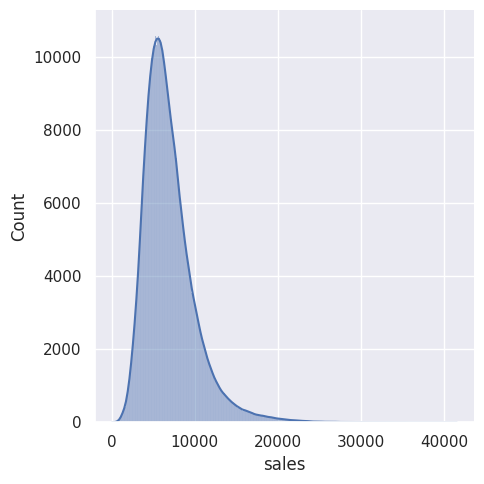

In [28]:
# checking distribuition 
sns.displot( df4['sales'], kde='hist');

### 3.1.2 Numerical Variables

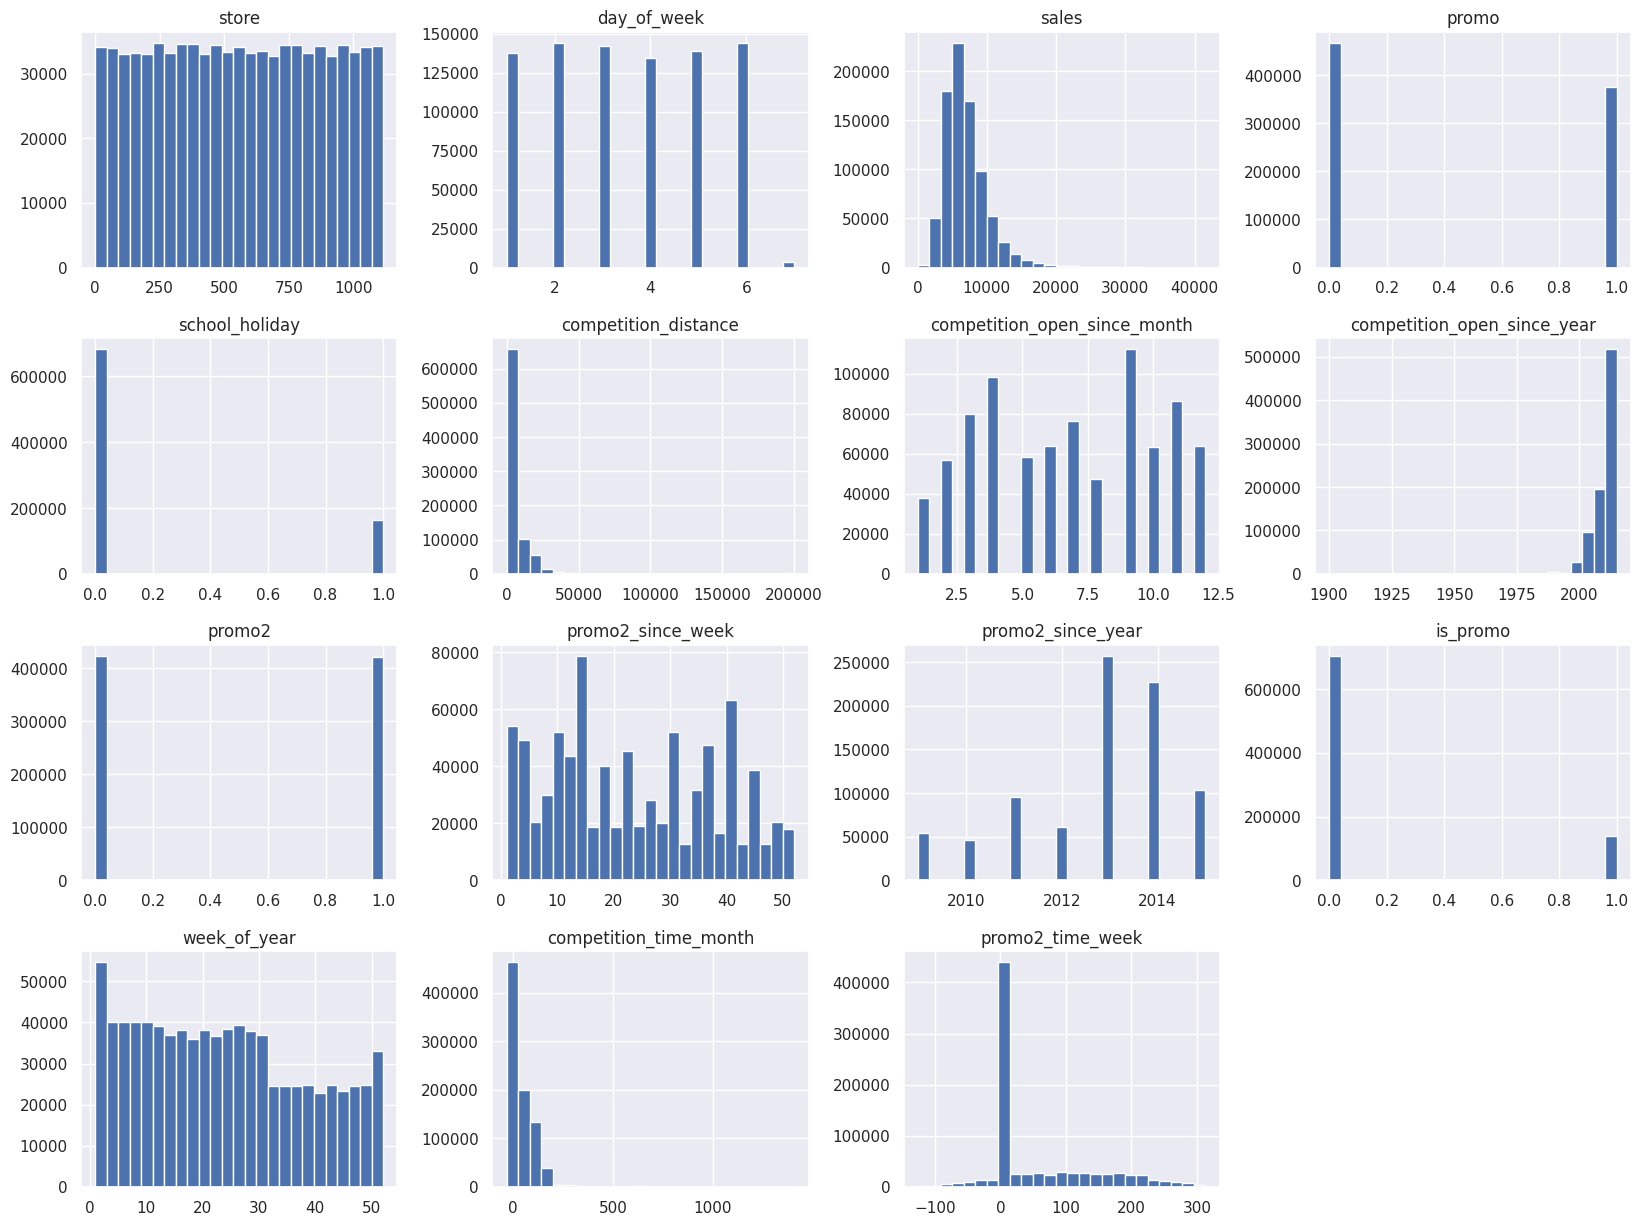

In [29]:
# cheking distribuition
df4.select_dtypes( include=['int64', 'float64'] ).hist( bins=25, figsize=(20, 15) );

**Observações**
- As variáveis, em sua maioria, possuem comportamentos variados e isso é um bom indicativo para os resultados do modelo.
- A variável "day_of_week" foi impactada pela remoção dos dias em que as lojas estão fechadas.


### 3.1.3 Categorical Variables

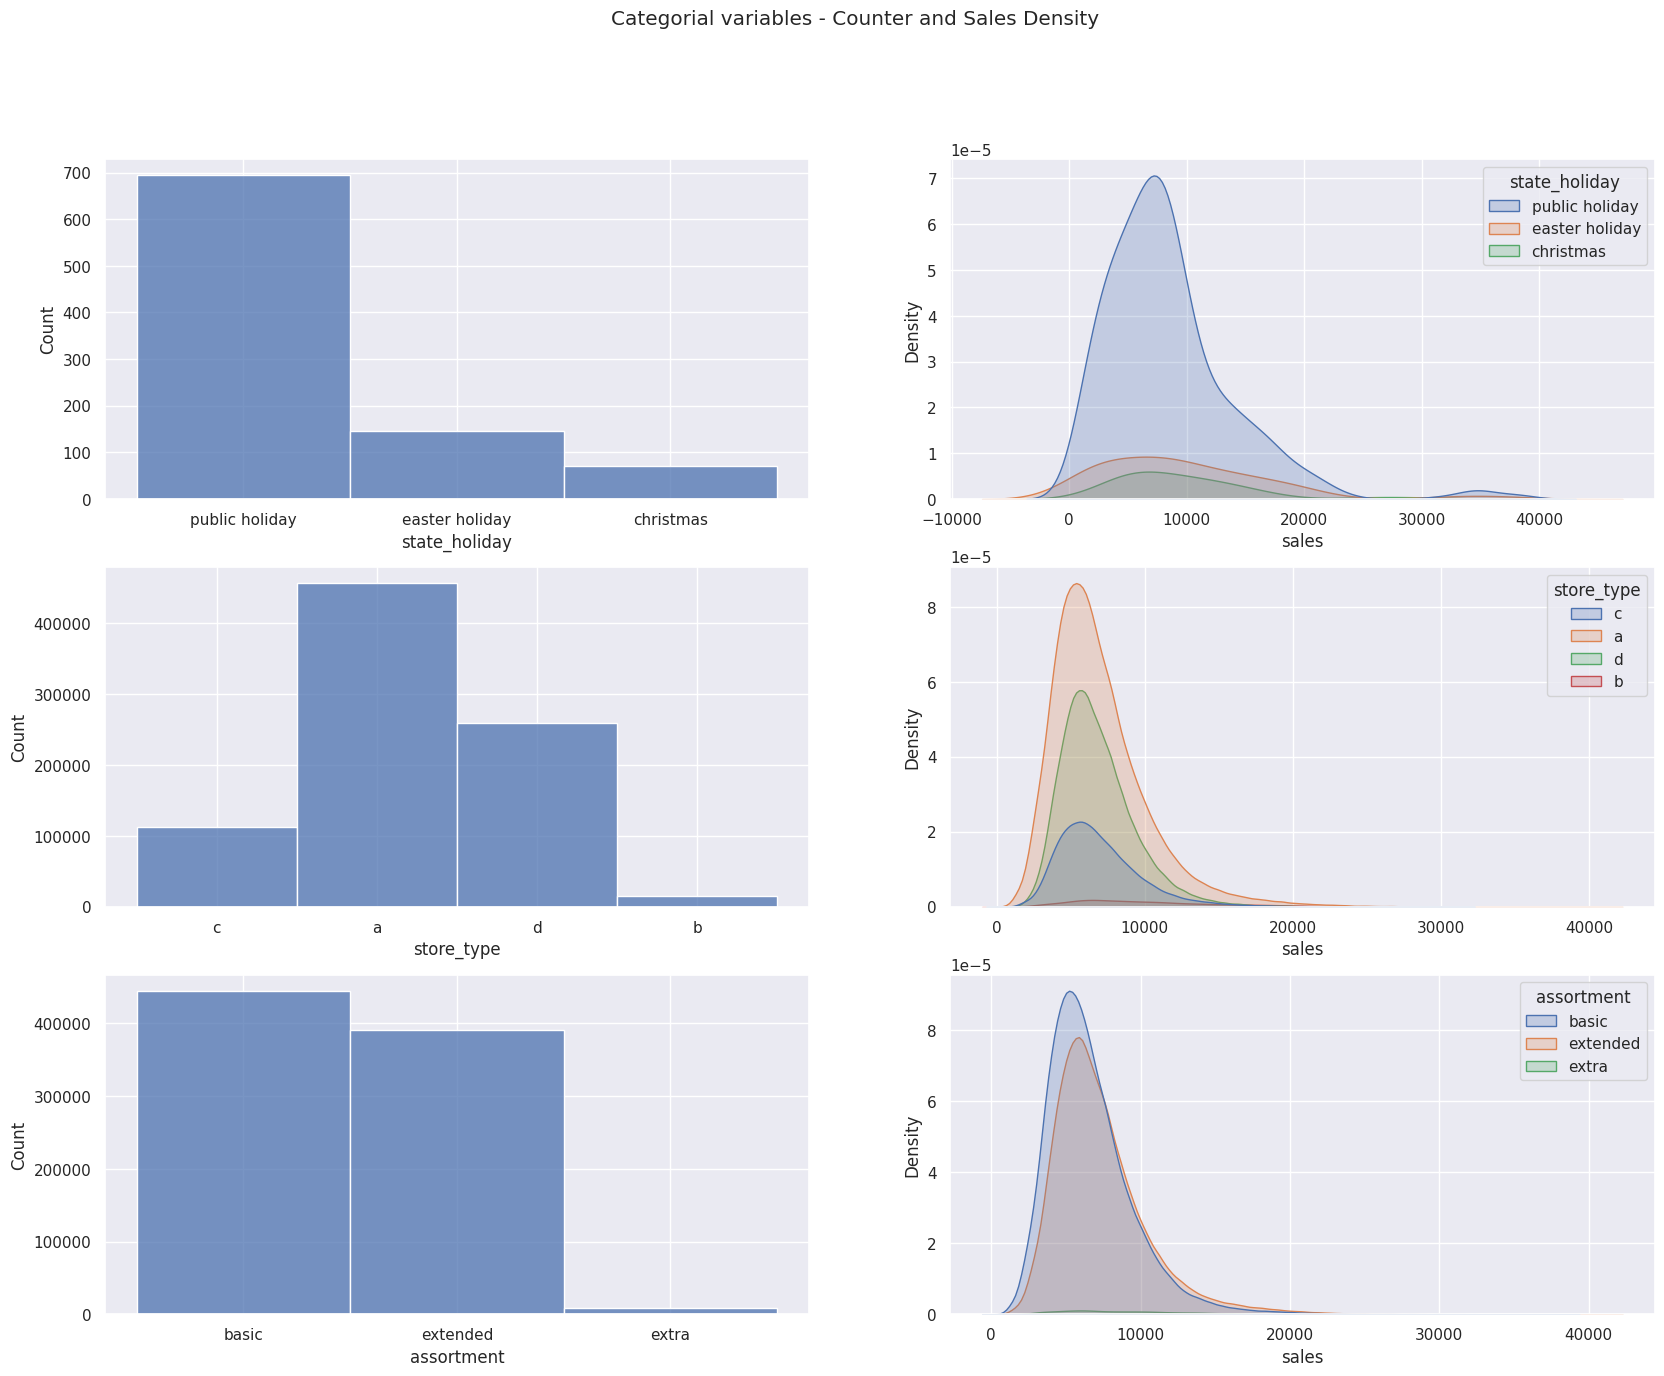

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Categorial variables - Counter and Sales Density')

# state_holiday
sns.histplot( data=df4[ df4['state_holiday'] !=  'regular day' ]['state_holiday'], ax=axes[0,0] );
sns.kdeplot ( data=df4[ df4['state_holiday'] !=  'regular day' ][['state_holiday', 'sales']], x='sales',  hue='state_holiday', fill=True, ax=axes[0,1] );

# store_type
sns.histplot( ax=axes[1,0], data=df4['store_type'] );
sns.kdeplot  ( ax=axes[1,1], data=df4[['store_type', 'sales']], x='sales',  hue='store_type', fill=True );

# assortment
sns.histplot( ax=axes[2,0], data=df4['assortment'] );
sns.kdeplot  ( ax=axes[2,1], data=df4[['assortment', 'sales']], x='sales',  hue='assortment', fill=True );


**Observações**
- O campo "state_holiday" 

## 3.2 Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais (STORE)

***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

***ASSORTMENT*** Apresenta comportamento variável na classe "extra", mas com um volume pequeno de dados, portanto, relevância BAIXA para o modelo

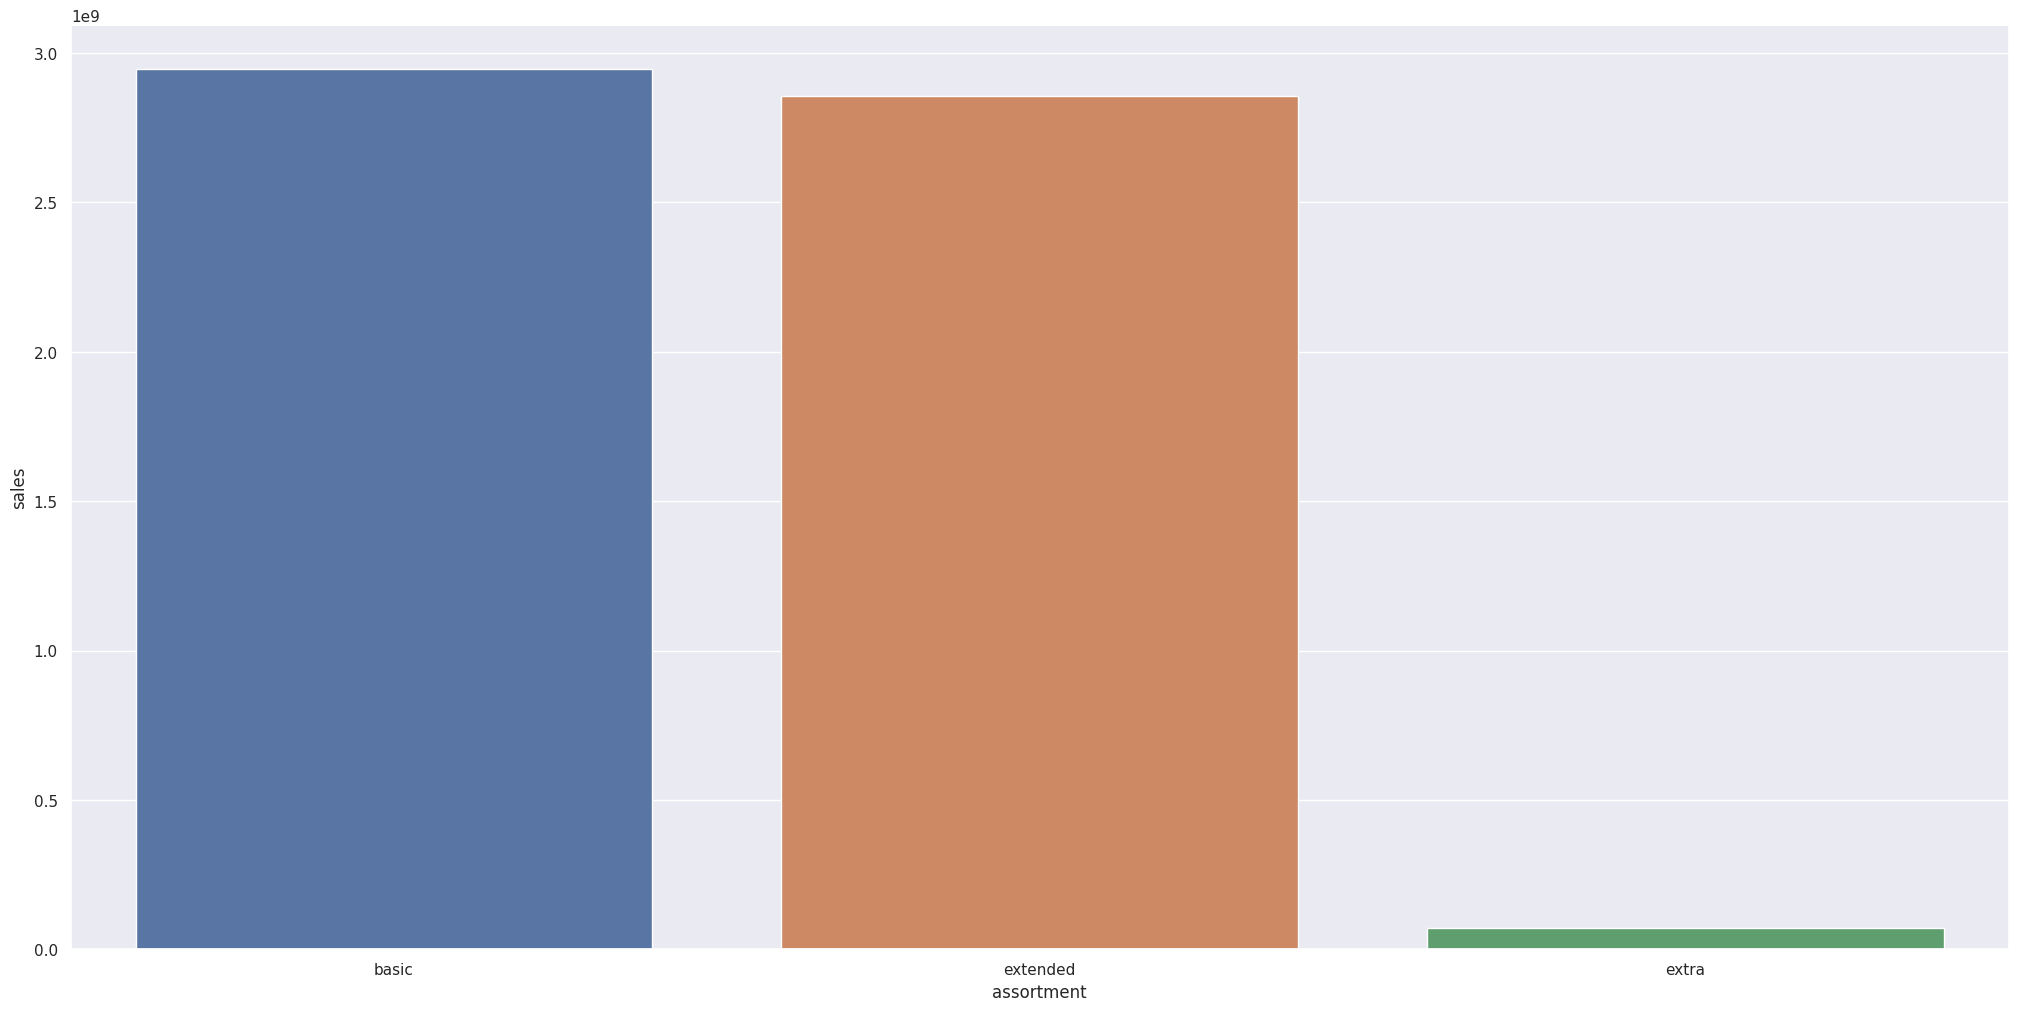

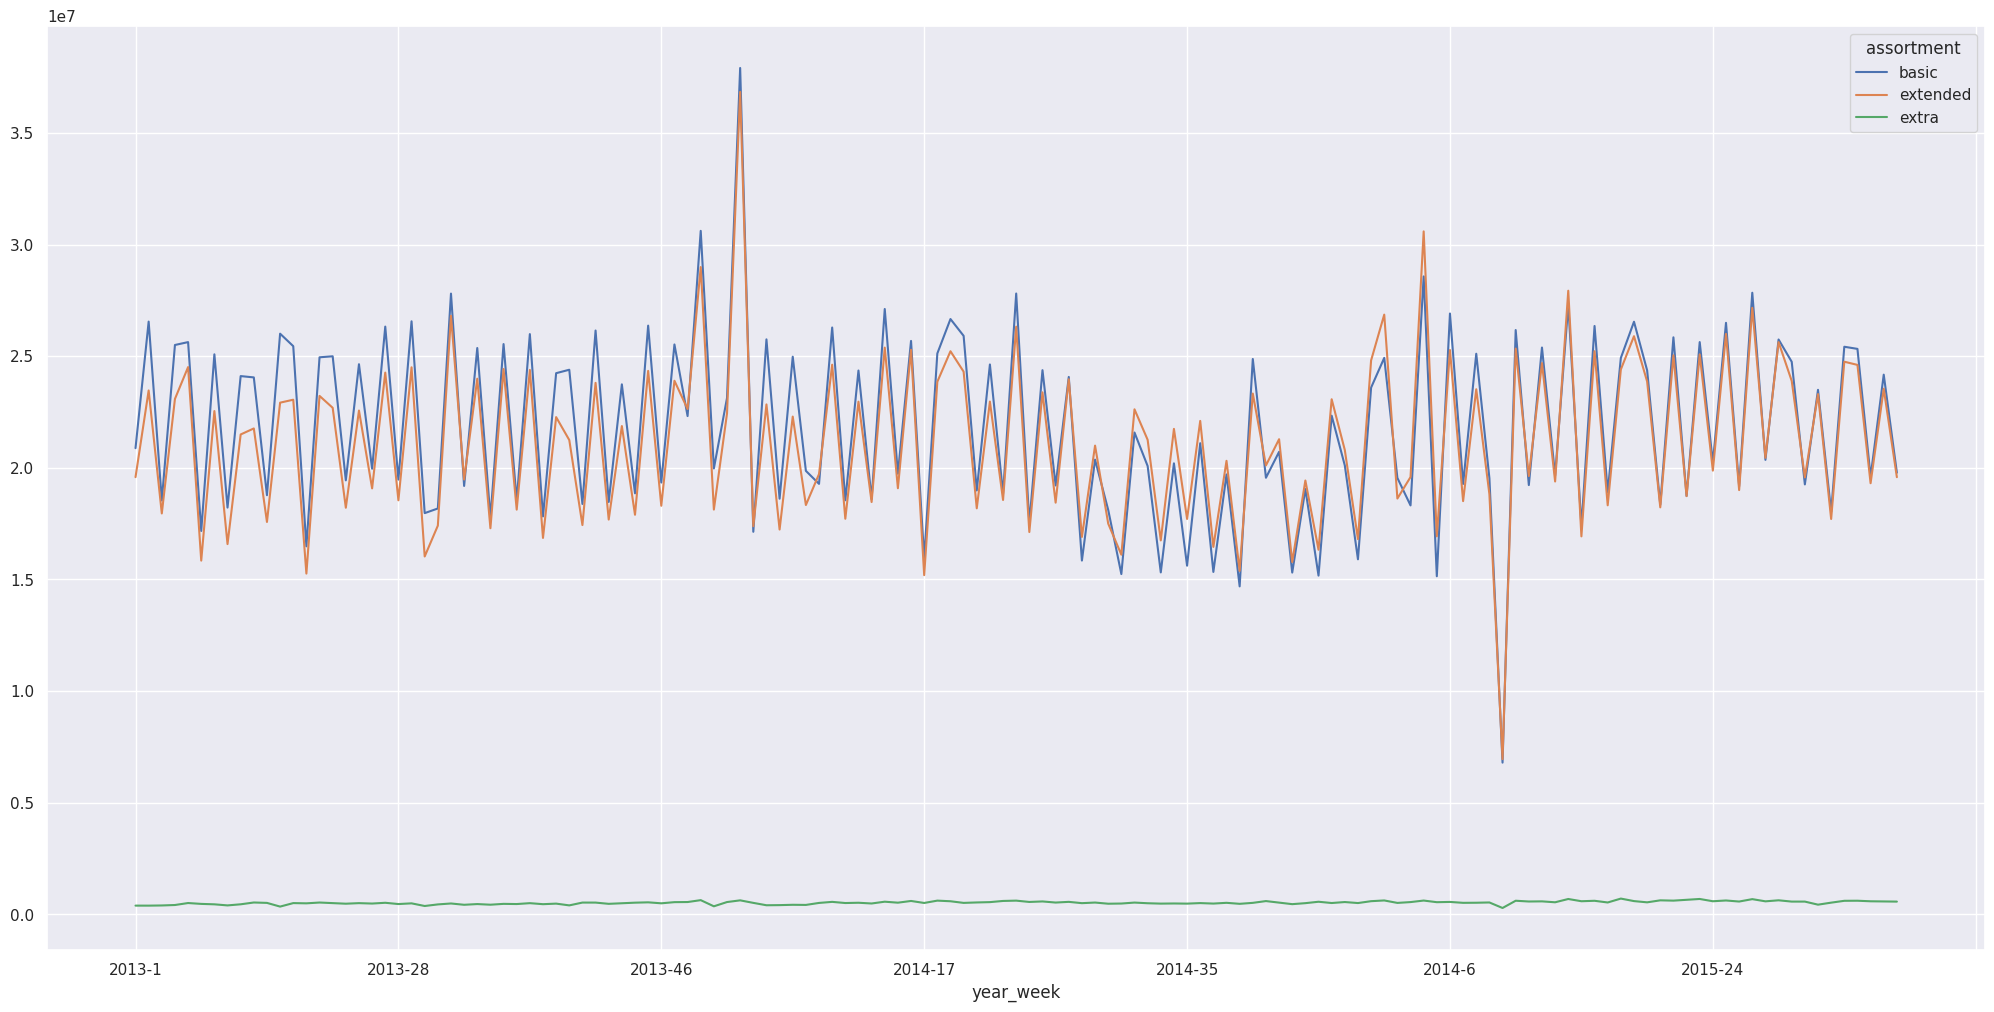

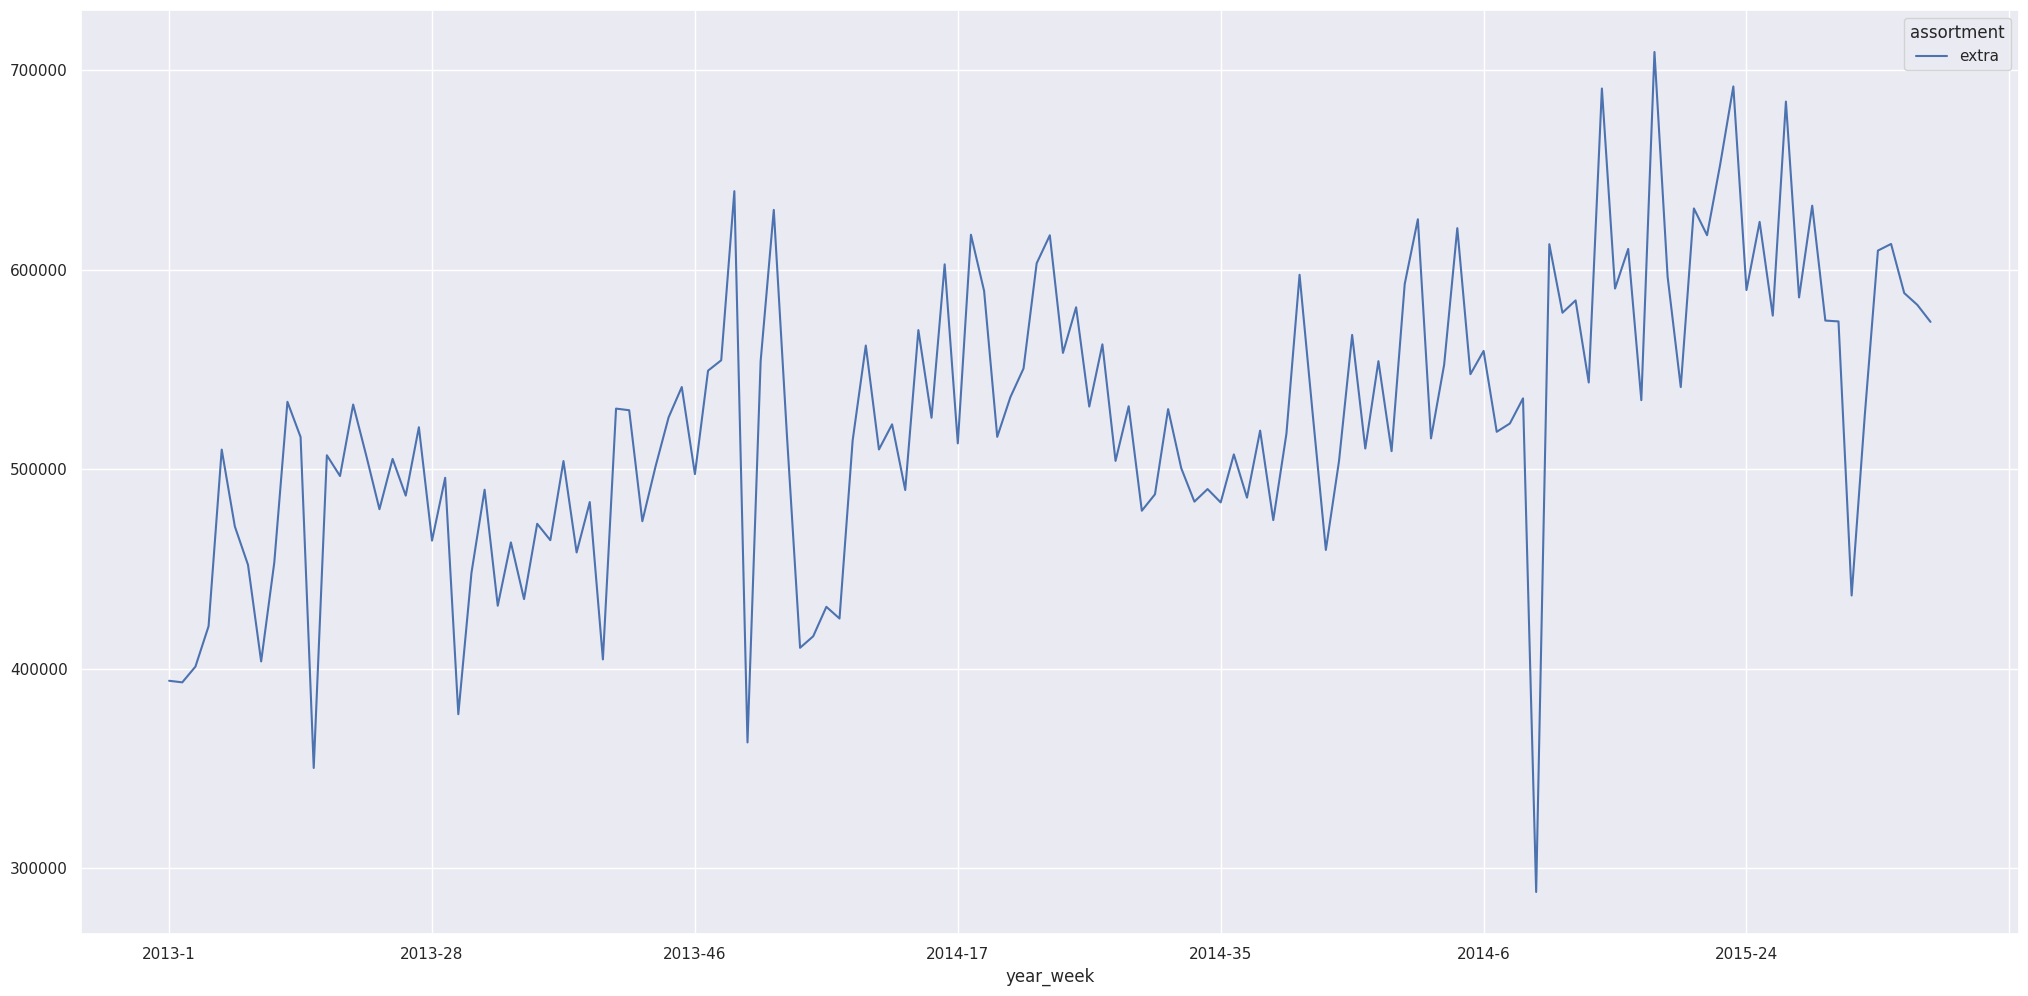

In [31]:
# sales x assortments - total
aux = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux );

# sales x assortments - timeline 
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

# sales x assortments - only "extra" assortment
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos (STORE)

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

**COMPETITION_DISTANCE** apresenta uma correlação FRACA com a variável resposta

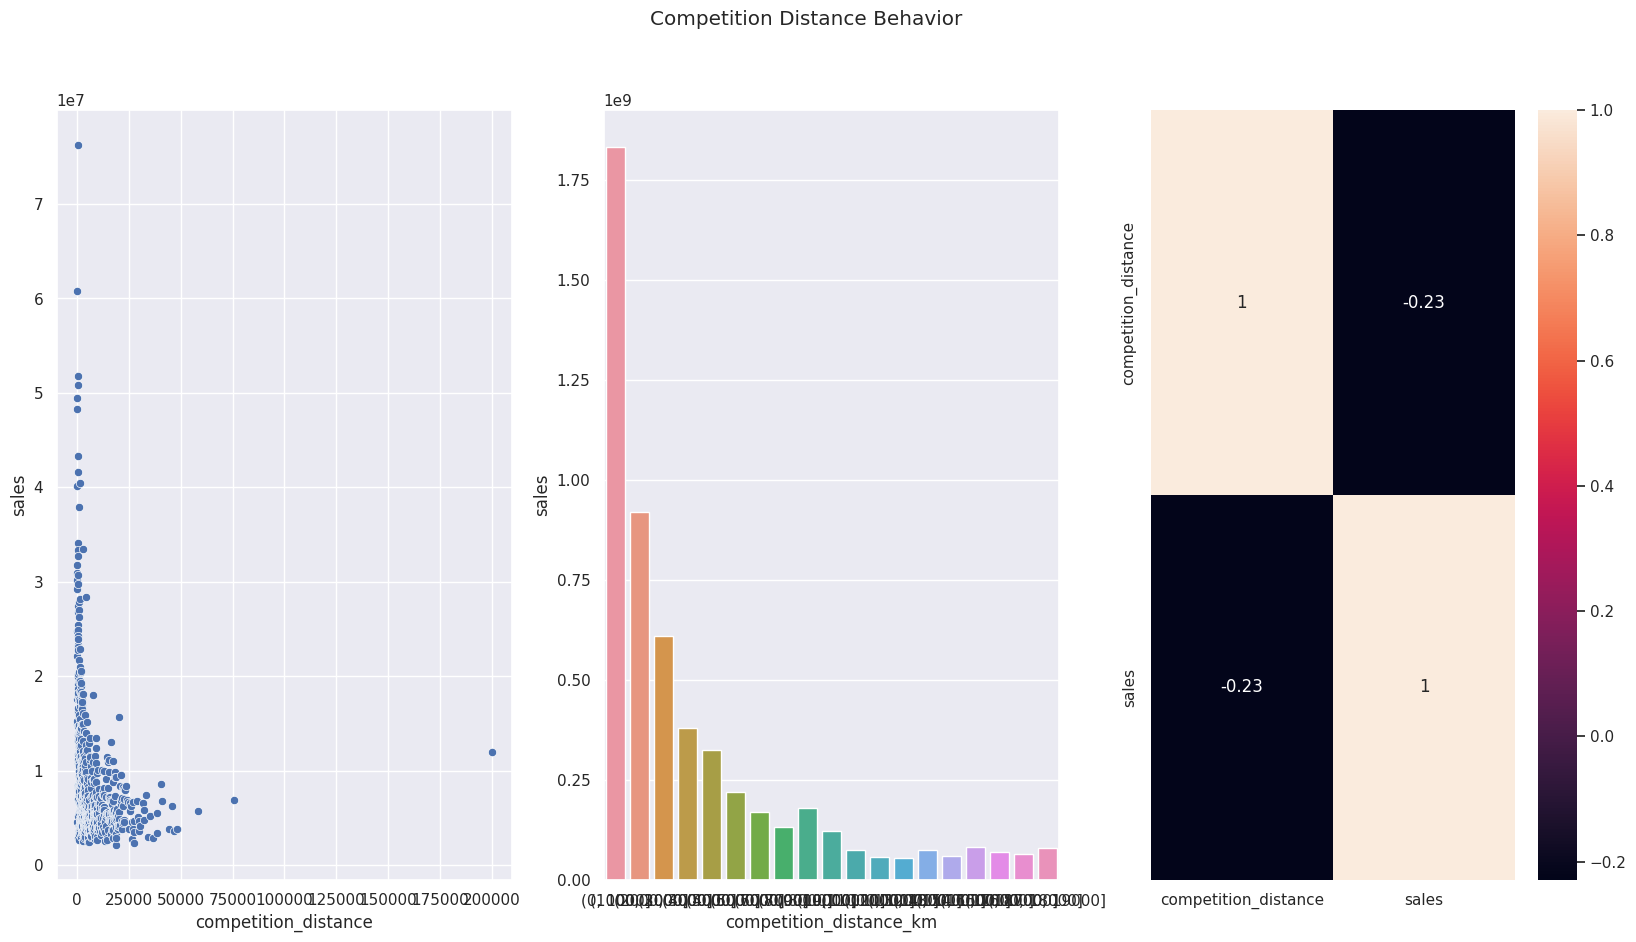

In [32]:

fig, axes = plt.subplots(1, 3, figsize=(20, 10) )
fig.suptitle('Competition Distance Behavior')


# sales x competition_distance - total
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( ax=axes[0], x='competition_distance', y='sales', data=aux1 );


# sales x competition_distance - grouped by km
competition_distance_km = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_km'] = pd.cut( aux1['competition_distance'], bins=competition_distance_km )
aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()
sns.barplot( ax=axes[1], x='competition_distance_km', y='sales', data=aux2 );


# sales x competition_distance corr method
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[2] );


### H3 - Lojas com competidores a mais tempo deveriam vender mais (STORE)



**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

**COMPETITION_TIME_MONTH** possui um correlação com a variável resposta muito próxima de ZERO, portanto, BAIXA CORRELAÇÃO

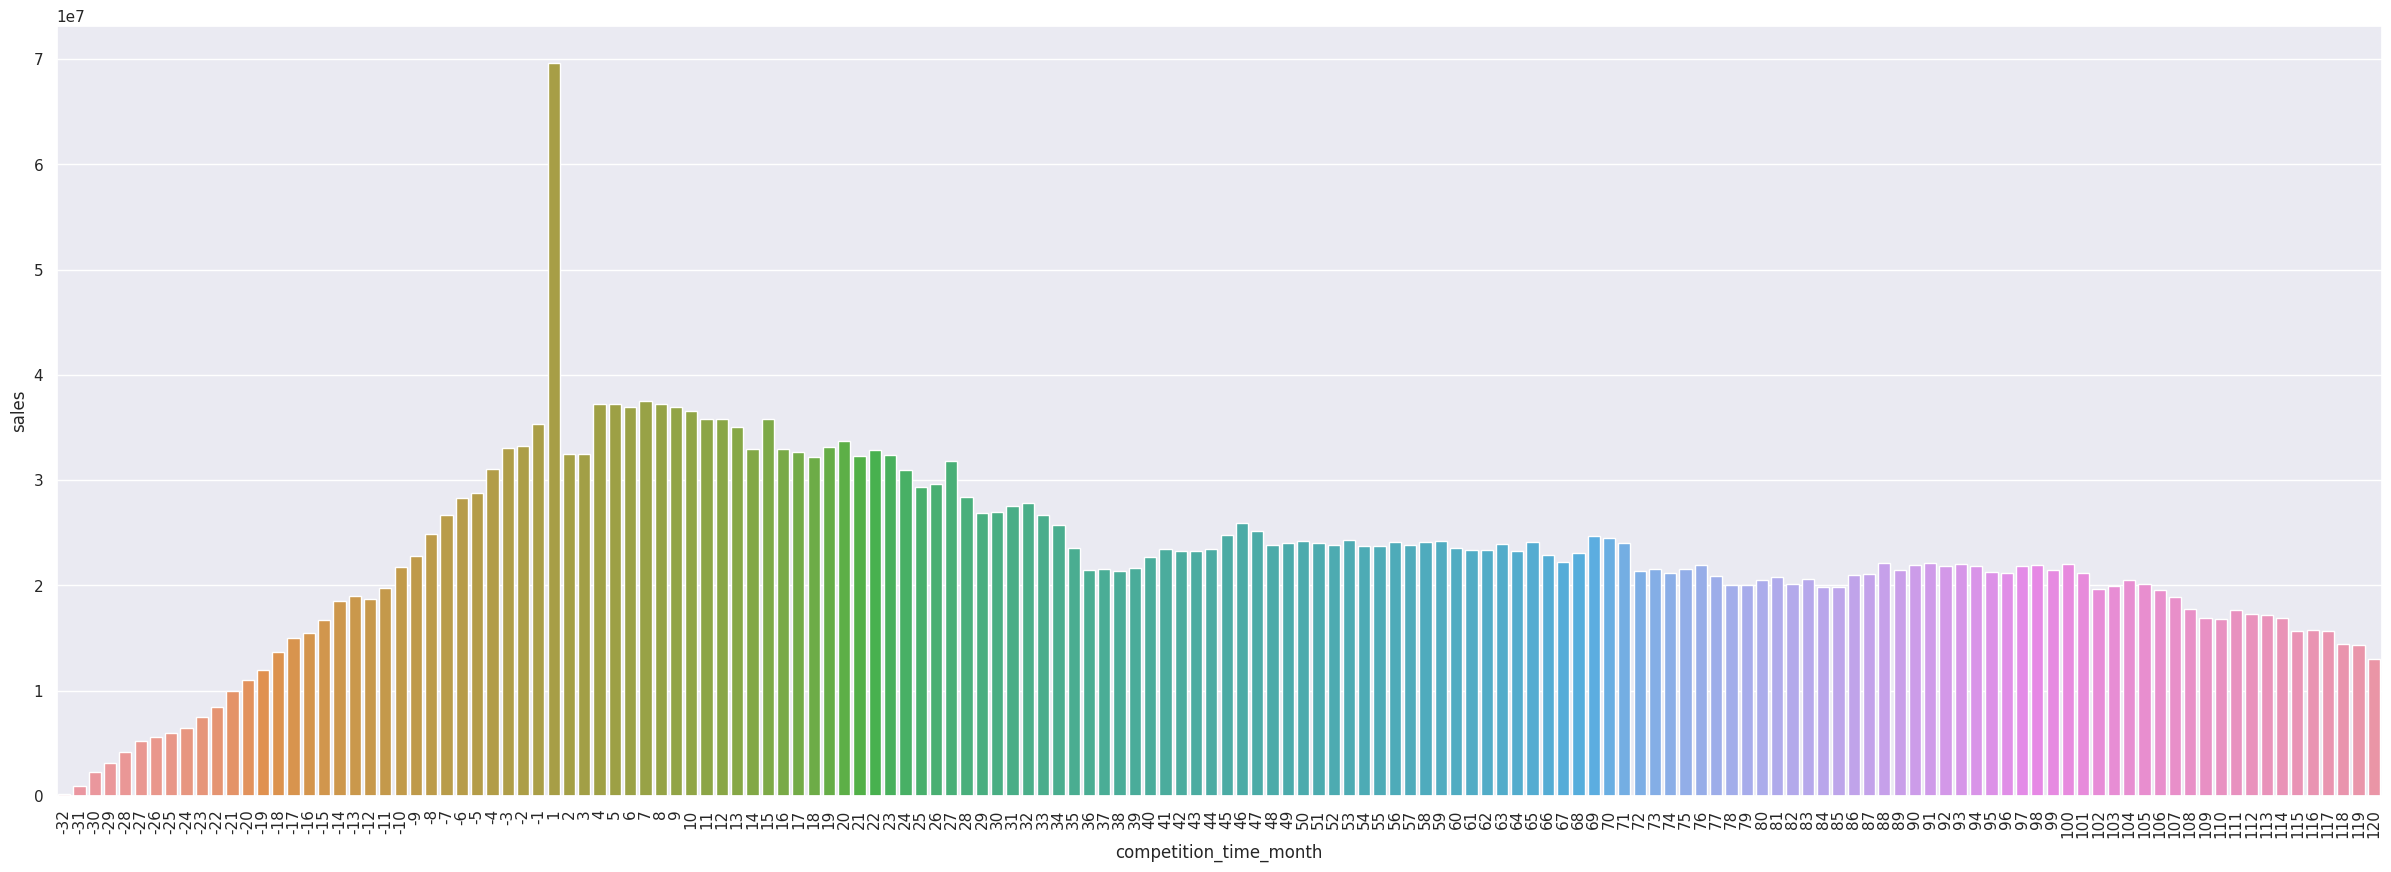

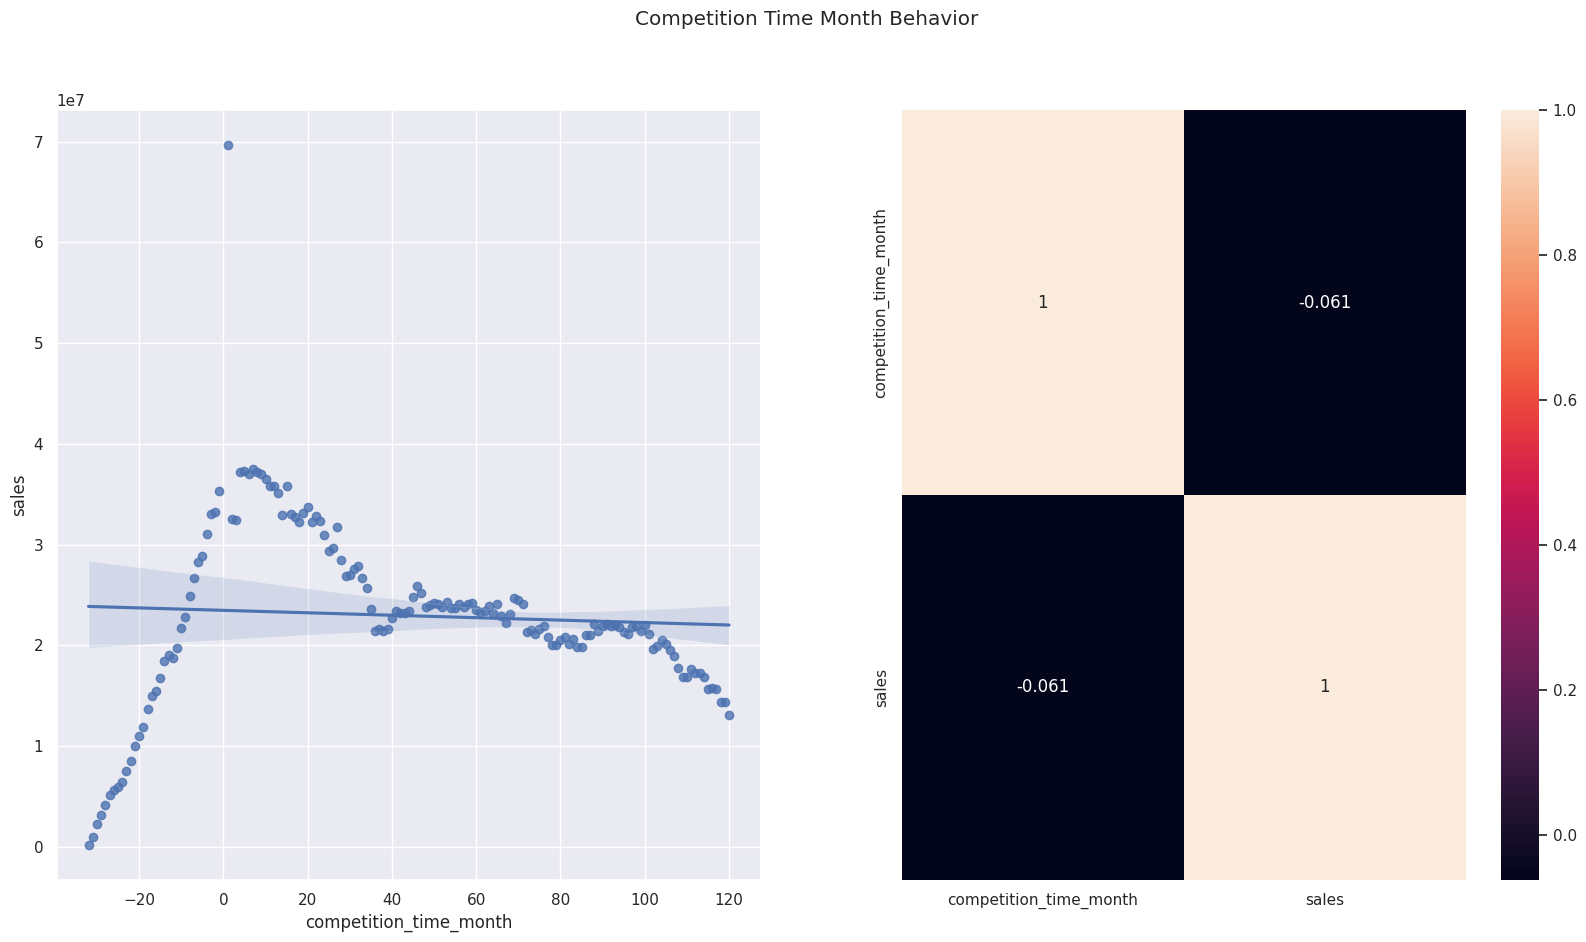

In [33]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux1 = aux1[ ( aux1['competition_time_month'] != 0 ) & ( aux1['competition_time_month'] <= 120 ) ]

plt.figure(figsize=(30,10));
plt.xticks( rotation='vertical');
sns.barplot( x='competition_time_month', y='sales', data=aux1 );

fig, axes = plt.subplots(1, 2, figsize=(20, 10) )
fig.suptitle('Competition Time Month Behavior')

# sales x competition_time_month 
sns.regplot( x='competition_time_month', y='sales', data=aux1, ax=axes[0] );

# sales x competition_distance corr method
sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)





**FALSA** Lojas com PROMOÇÔES ATIVAS A MAIS TEMPO vendem MENOS depois de um certo período de promoção

**PROMO2_TIME_WEEK** possui uma correlação FRACA com a variável resposta

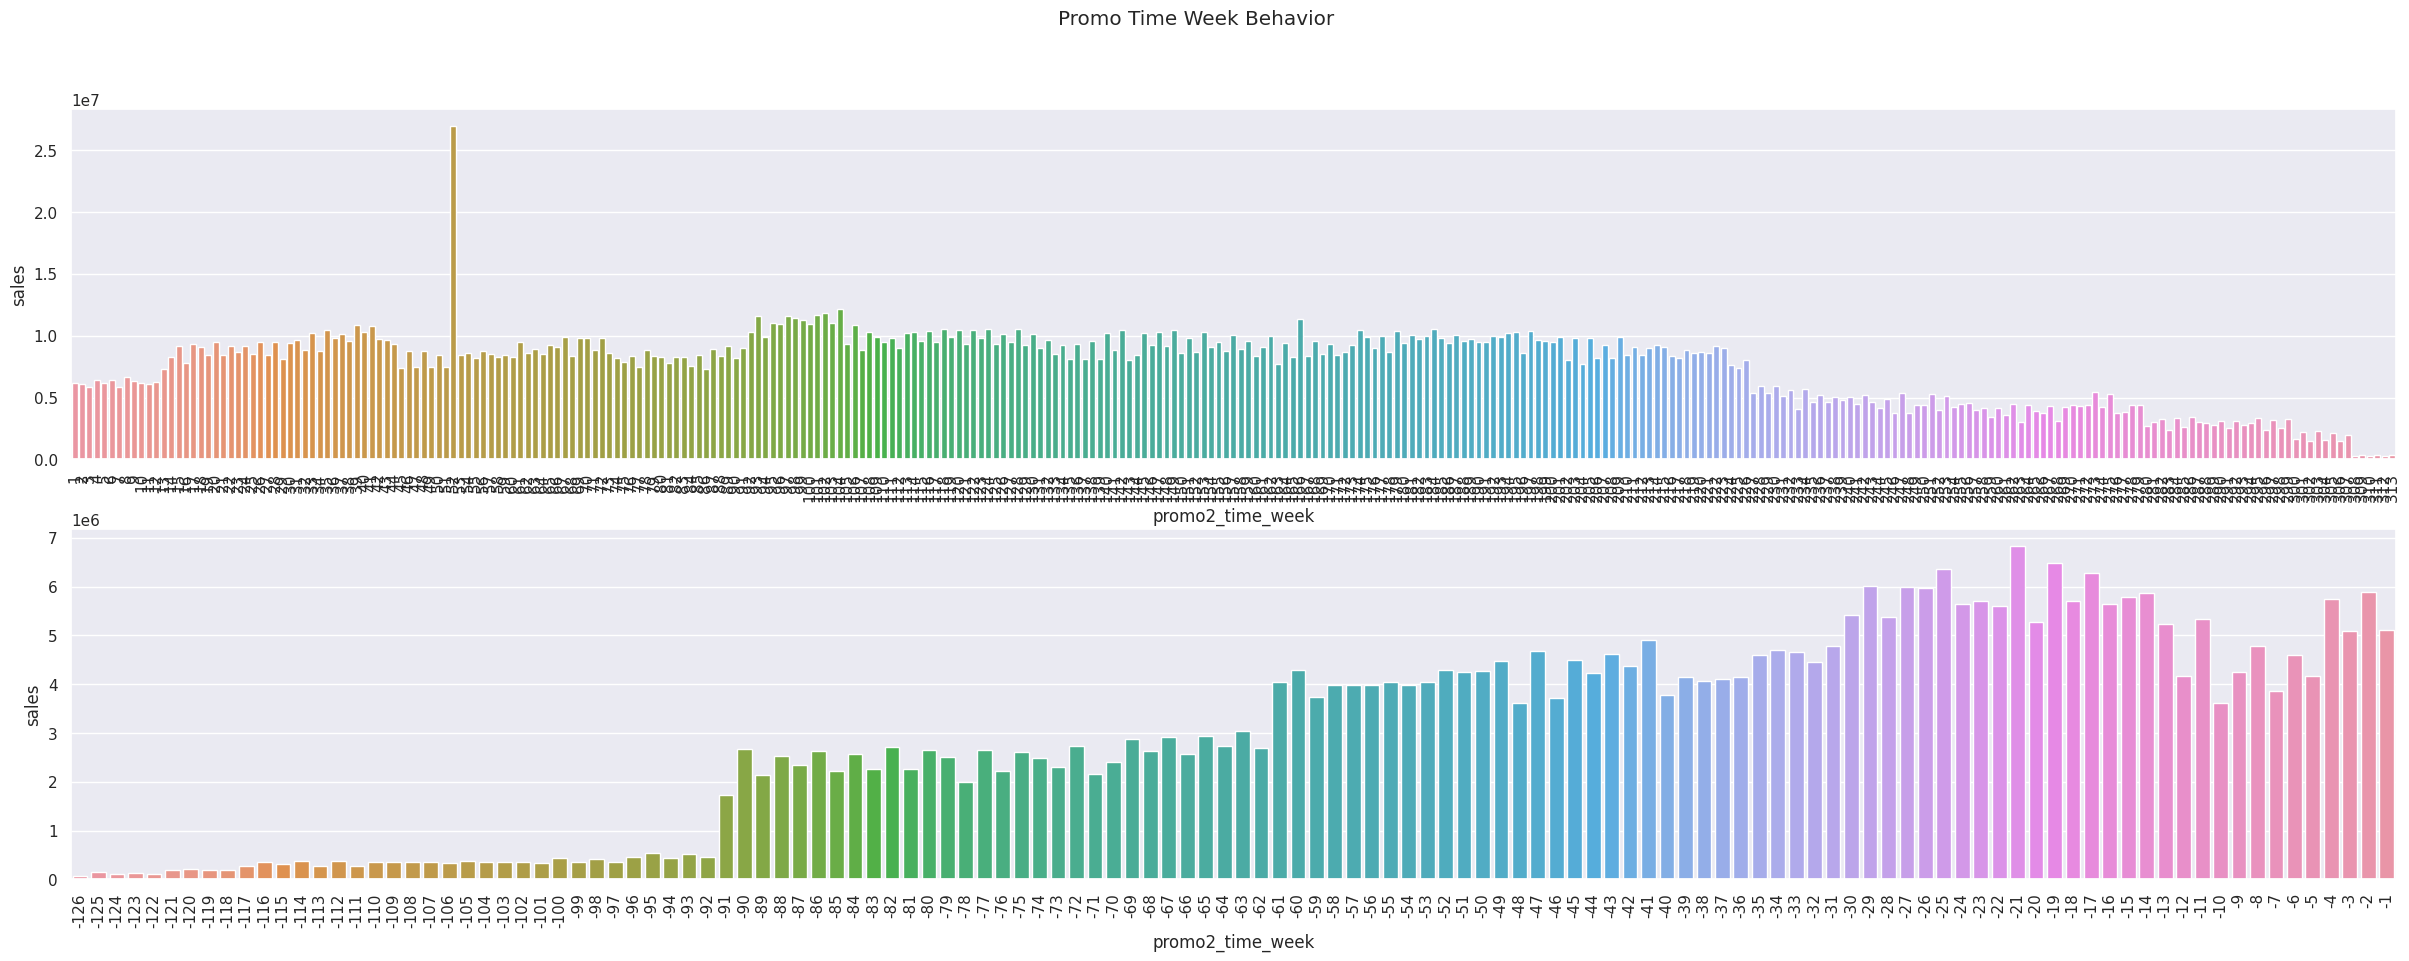

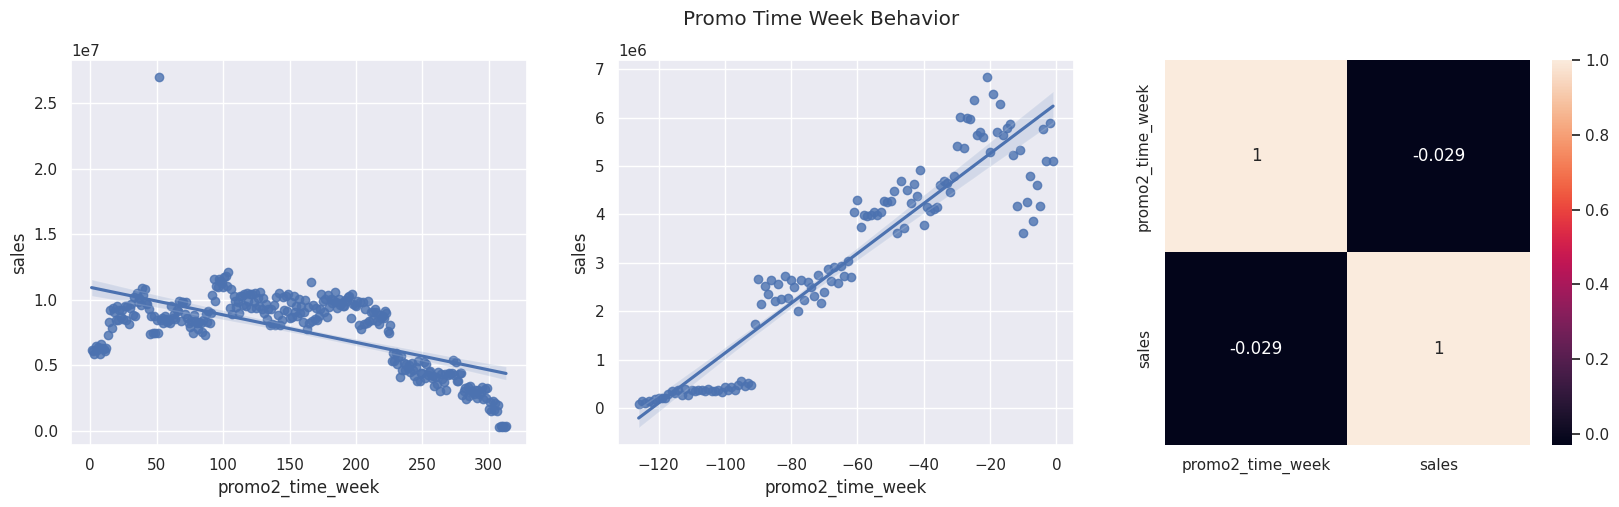

In [34]:
aux1 = df4[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
#sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

# extended promo
aux2 = aux1[ aux1['promo2_time_week'] > 0 ] 

# regular promo
aux3 = aux1[ aux1['promo2_time_week'] < 0 ] 

fig, axes = plt.subplots(2, 1, figsize=(30, 10),  )
fig.suptitle('Promo Time Week Behavior')

axes[0].xaxis.set_tick_params( rotation=90 )
axes[1].xaxis.set_tick_params( rotation=90 )


sns.barplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.barplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Promo Time Week Behavior')

sns.regplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.regplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### <s> H5 - Lojas com mais dias de promoção deveriam vender mais (PRODUCT) </s>

**ON HOLD** Será necessária a criação de uma variável com a quantidade de dias em promoção. Fica para a próxima rodada do CRISP-DS

### H6 - Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)

**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

**PROMO E PROMO2** aprensentam o mesmo comportamente em relação as vendas, portanto, ambas apresentam um correlação FRACA com a variável resposta

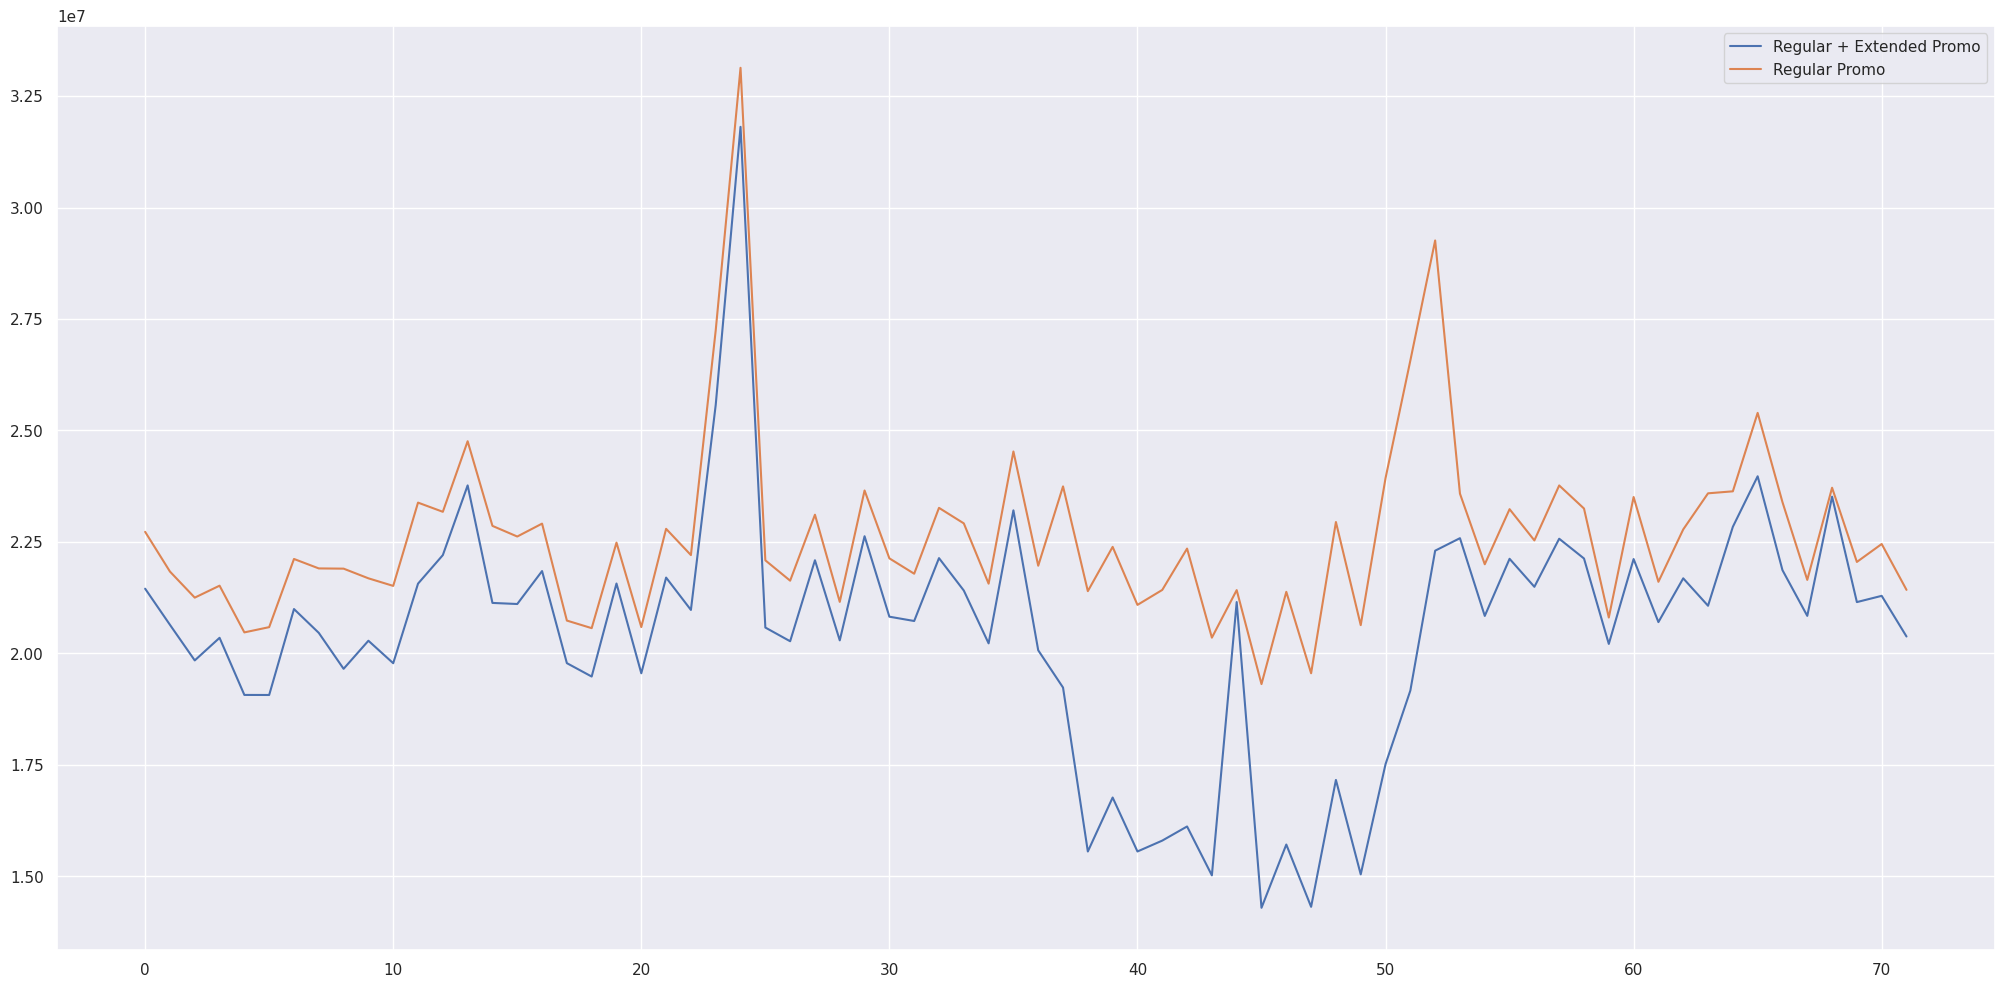

In [35]:
# regular and extended promo
aux1 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 1 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 0 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular + Extended Promo', 'Regular Promo'] );

### H7 -  Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**FALSA**, Lojas abertas durante o feriado de Natal vendem MENOS

**STATE_HOLIDAY** possui comportamentos distintos entre os tipos de feriados e por isso ter uma correlação FORTE com a variável resposta

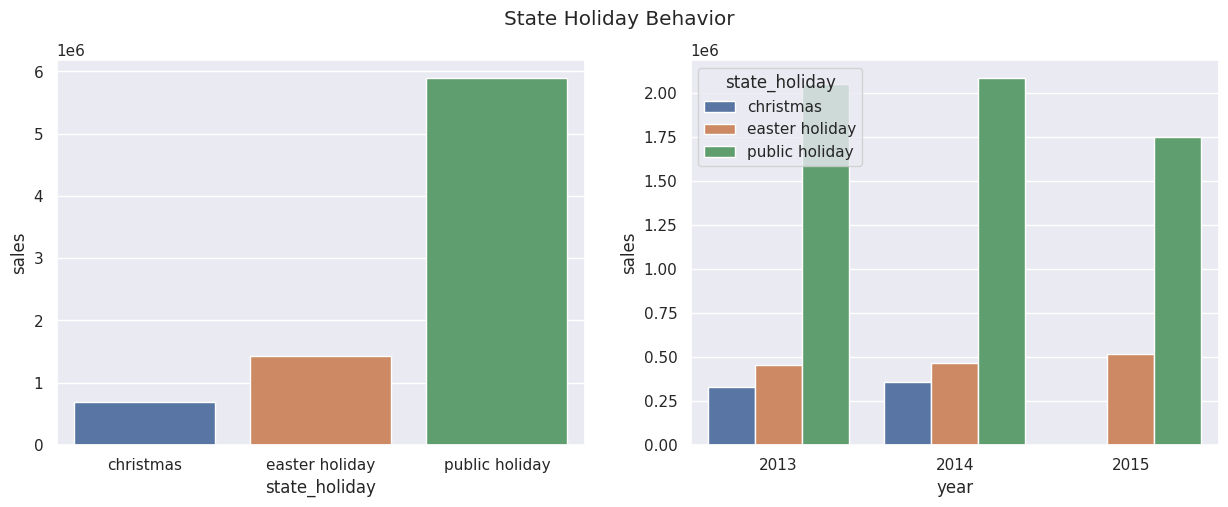

In [36]:
aux1 = df4[ df4['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
aux2 = df4[ df4['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5) )
fig.suptitle('State Holiday Behavior')

sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axes[0] );
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axes[1] );



### H8 - Lojas deveriam vender mais ao longo dos anos (TIME)

**FALSA** Lojas vendem MENOS ao longo dos anos

**YEAR** Possui uma correlação FORTE com a variável resposta

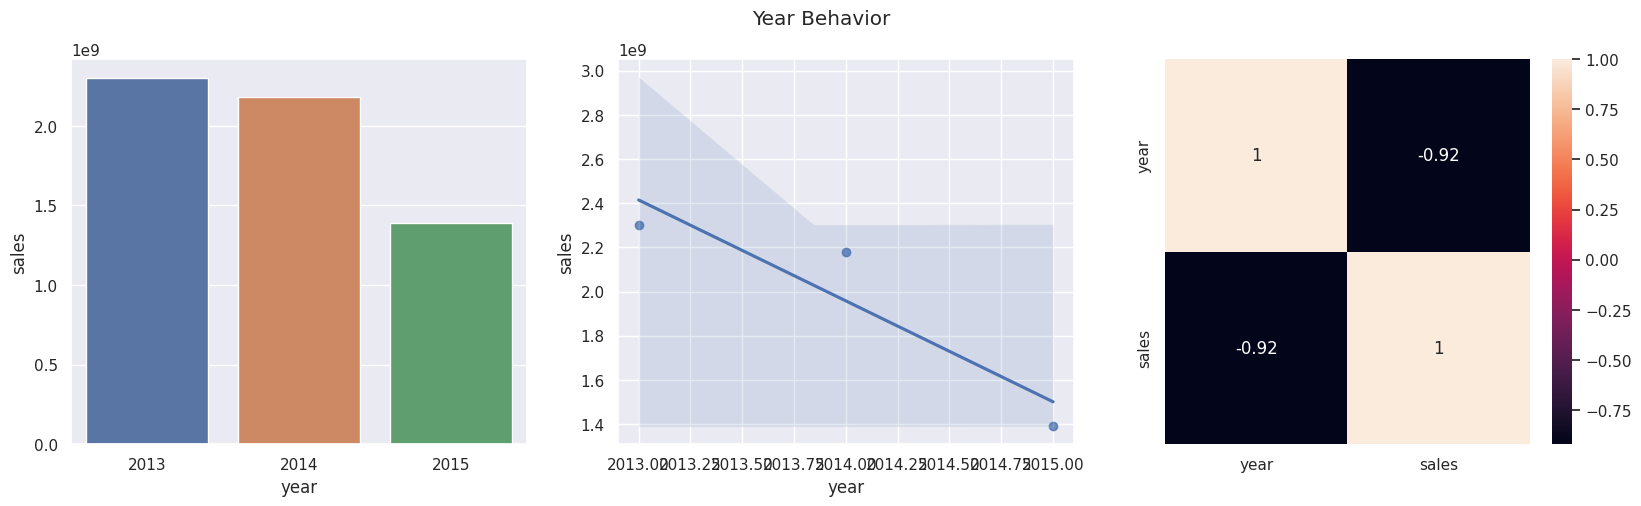

In [37]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Year Behavior')

sns.barplot( x='year', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='year', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### H9 - Lojas deveriam vender mais no segundo semestre do ano (TIME)

**FALSA** Lojas vendem MENOS no segundo semestre do ANO

**MONTH** possui uma ALTA correlação com a variável resposta

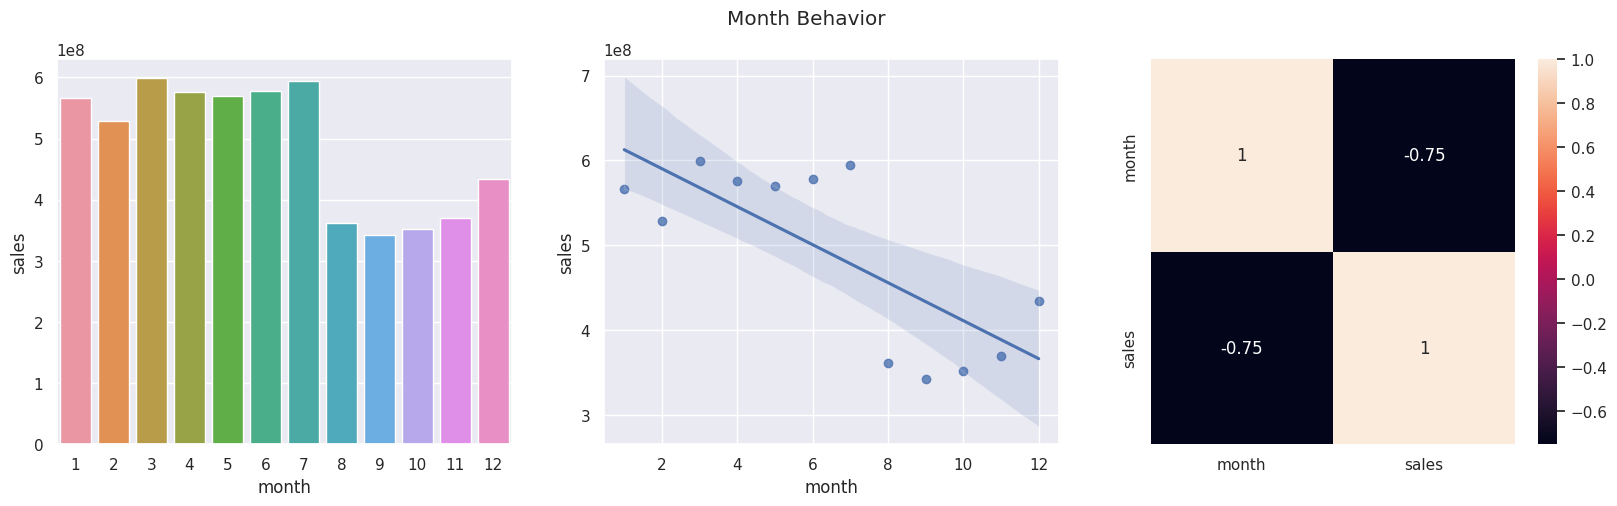

In [38]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Month Behavior')

sns.barplot( x='month', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='month', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

**DAY** possui uma correlação MÉDIA com a variável resposta

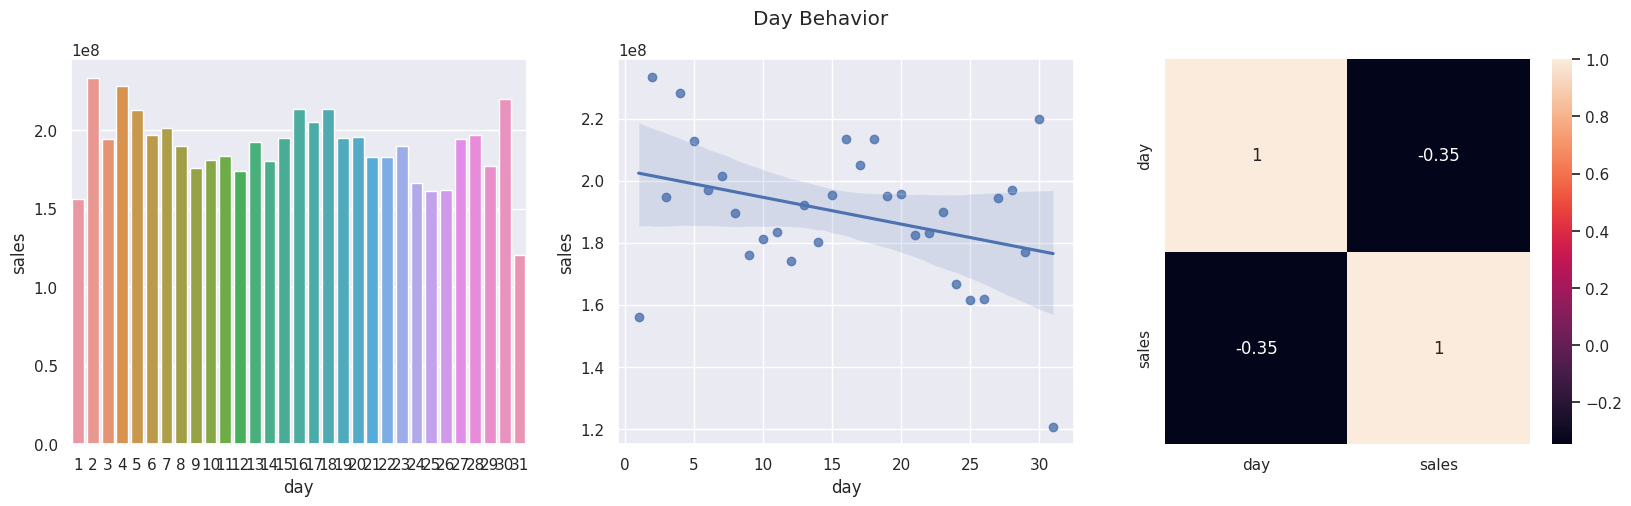

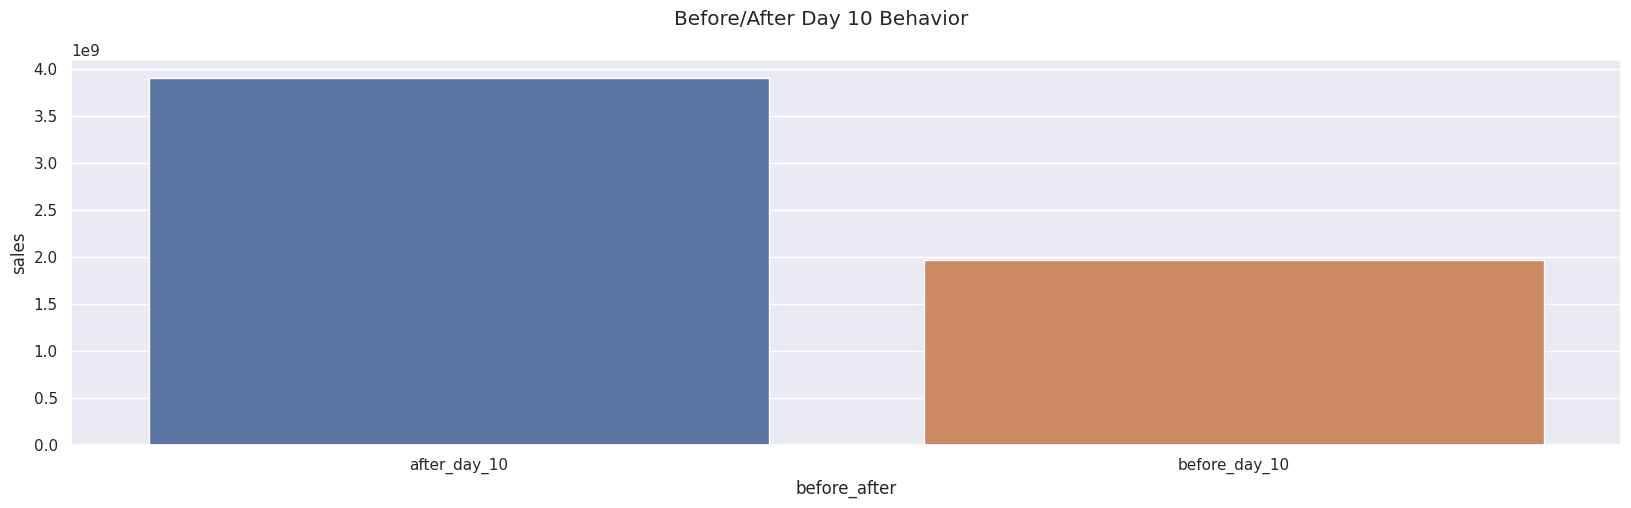

In [39]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day Behavior')

sns.barplot( x='day', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Before/After Day 10 Behavior')

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11 -  Lojas deveriam vender menos nos finais de semana (TIME)

**VERDADEIRA** Lojas vendem MENOS nos finais de semana

**DAY_OF_WEEK** possui uma correlação ALTA com a variável resposta

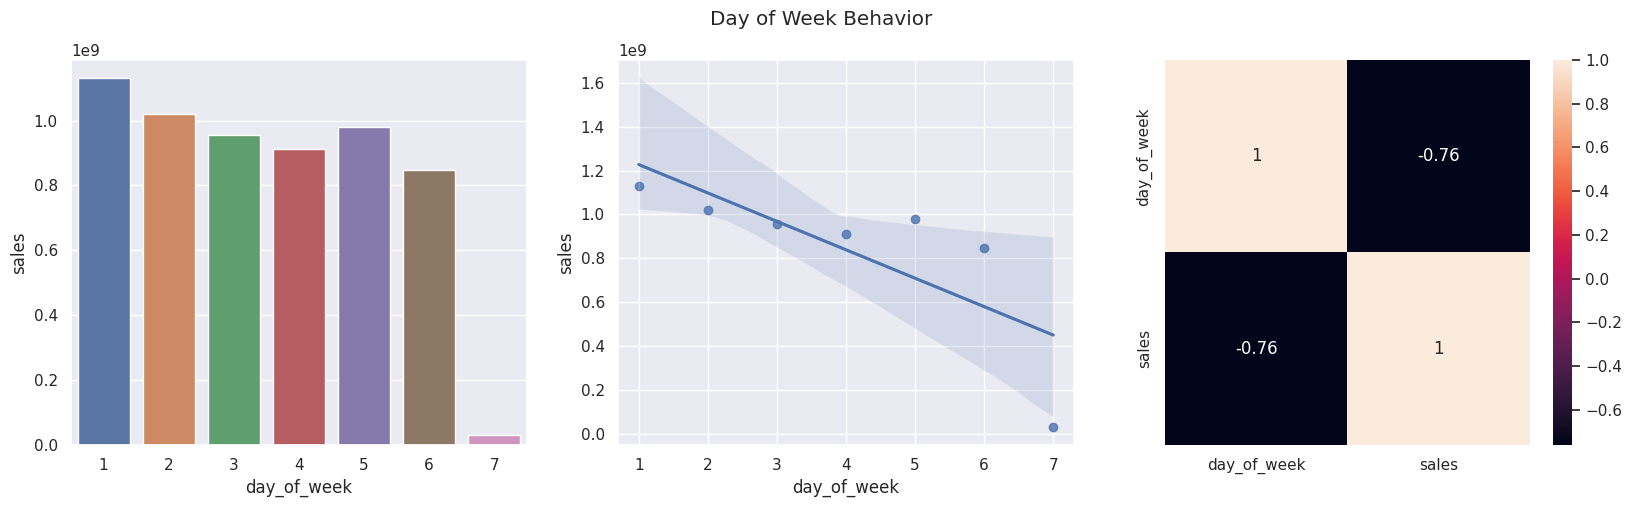

In [40]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day of Week Behavior')

sns.barplot( x='day_of_week', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day_of_week', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H12 - Lojas deveriam vender menos durante os feriados escolares (TIME)

**VERDADEIRA** Lojas vendem MENOS durante  os feriados escolares, exceto mês de agosto

**SCHOOL_HOLIDAY** possui uma correlação ALTA com a variável resposta, no entanto, possui pouca variação de comportamento

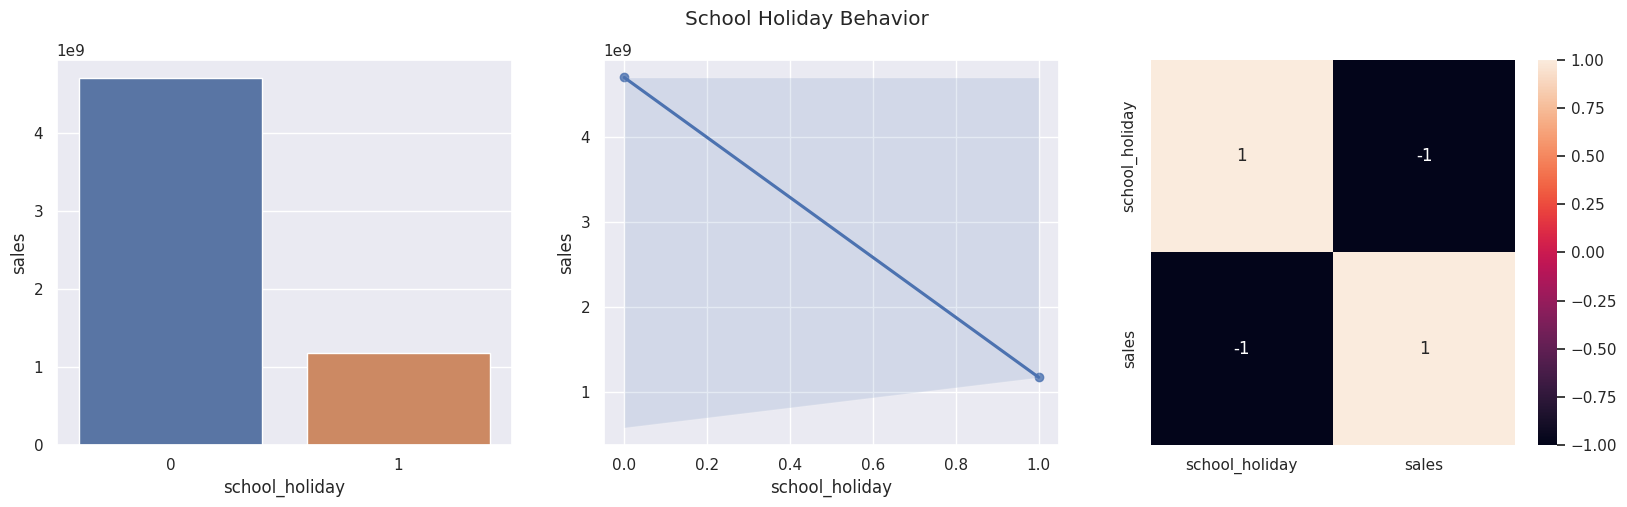

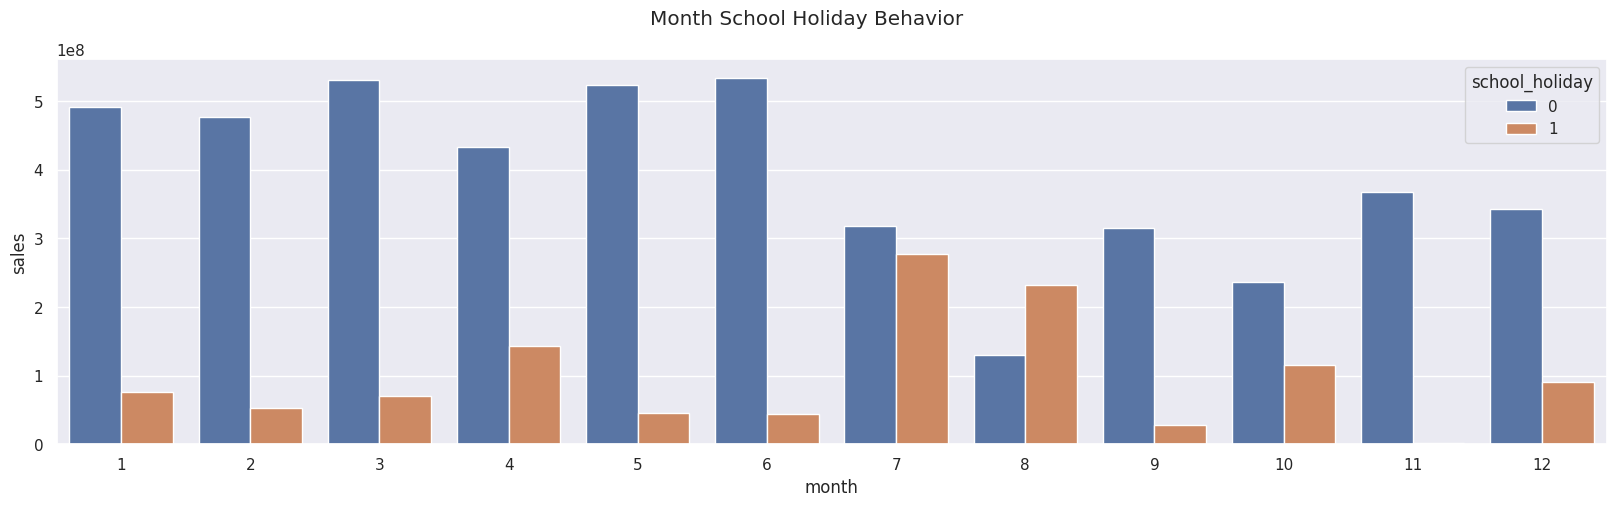

In [41]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('School Holiday Behavior')

sns.barplot( x='school_holiday', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Month School Holiday Behavior')

sns.barplot( x='month', hue='school_holiday', y='sales', data=aux2 );

### 3.2.1 Resumo das Hipóteses

In [42]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

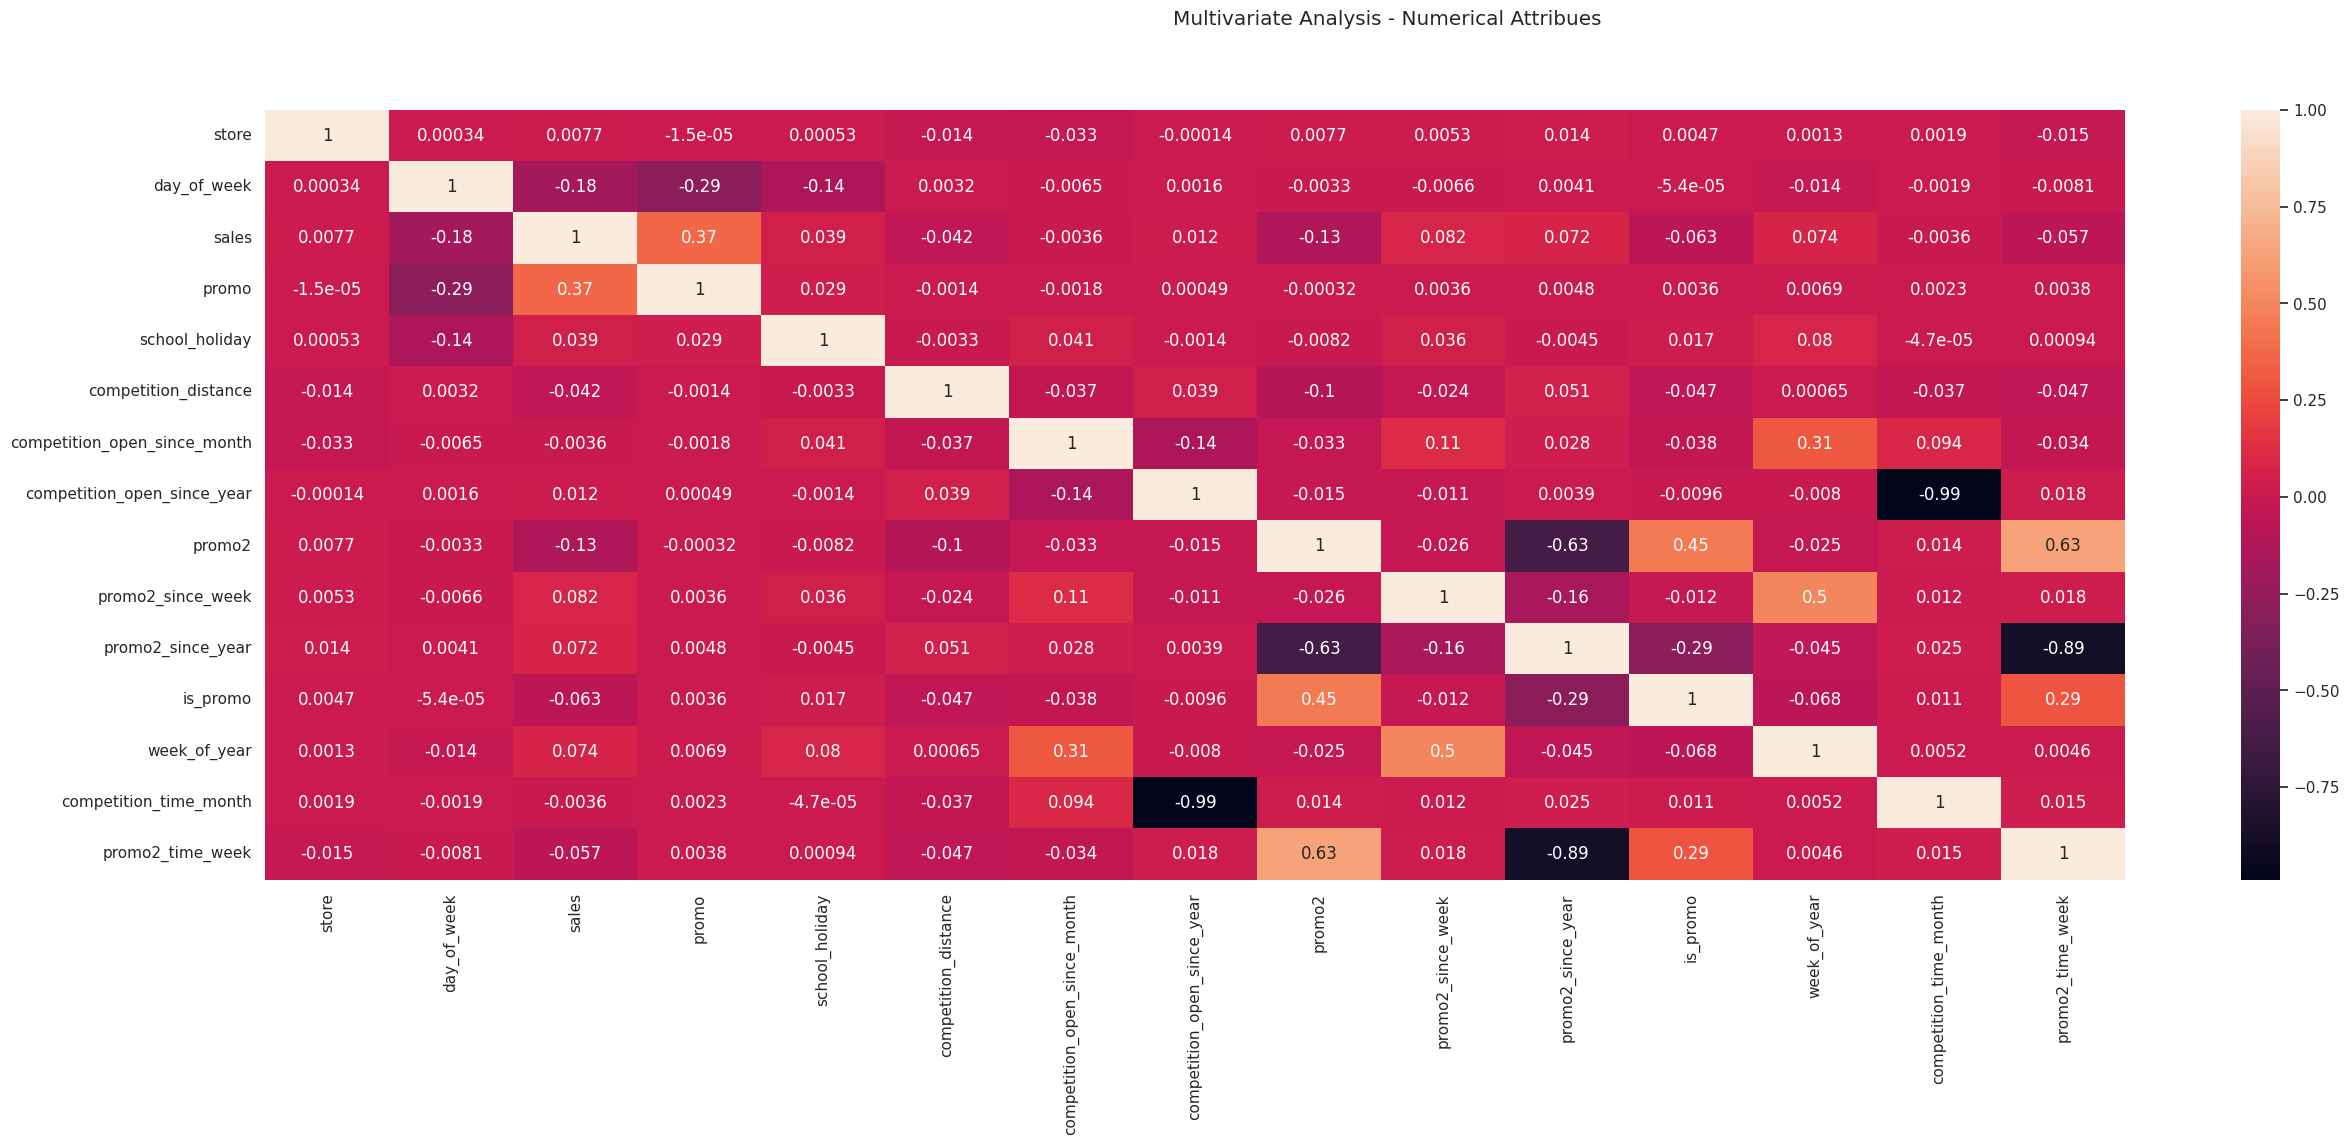

In [43]:
correlation = df4.select_dtypes( include=['int64', 'float64'] ).corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 10) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ')

sns.heatmap( correlation, annot=True );

### 3.3.2 Categorical Attributes

In [44]:
# create a dataframe with new categorical columns
cat = df4.select_dtypes( include='object' )
cat.sample(5)


,state_holiday,store_type,assortment,year_week
728247,regular day,a,basic,2013-38
963119,regular day,a,extended,2013-8
898558,regular day,c,basic,2013-16
274299,regular day,a,basic,2014-47
756366,regular day,a,extended,2013-34


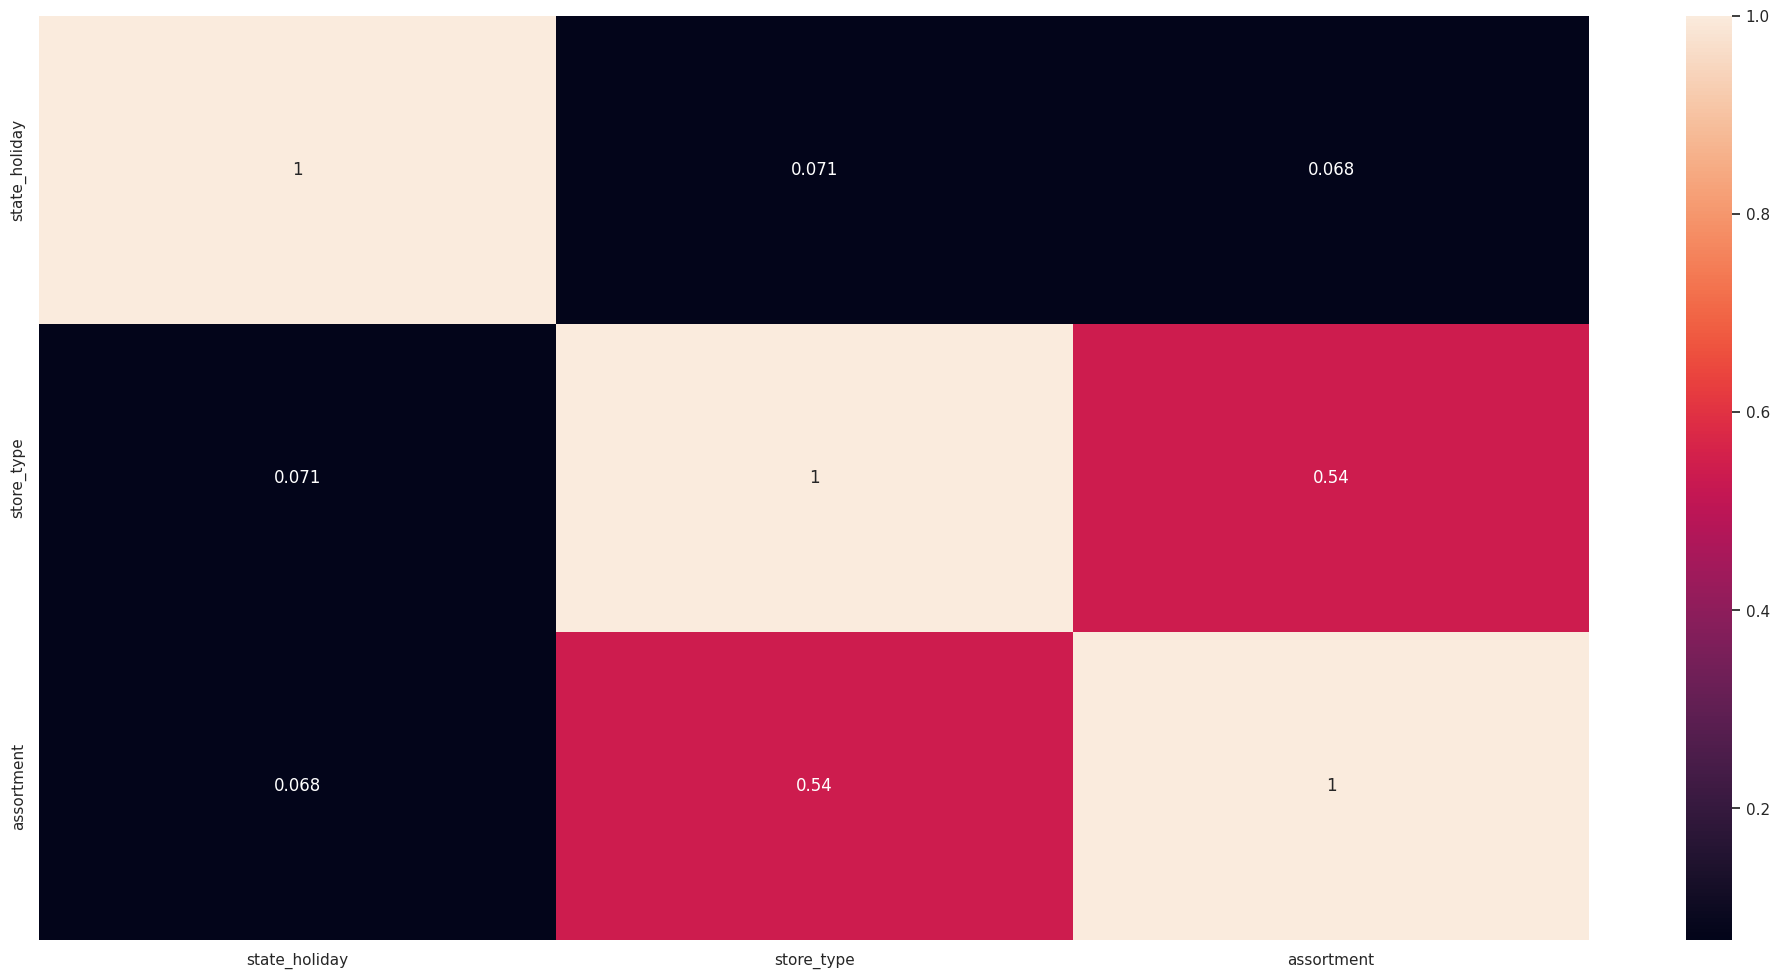

In [45]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cv2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cv3 = cramer_v( cat['state_holiday'], cat['assortment'] )

cv4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cv5 = cramer_v( cat['store_type'], cat['store_type'] )
cv6 = cramer_v( cat['store_type'], cat['assortment'] )

cv7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cv8 = cramer_v( cat['assortment'], cat['store_type'] )
cv9 = cramer_v( cat['assortment'], cat['assortment'] )

# create final dataframe
df = pd.DataFrame( { 'state_holiday' : [cv1, cv2, cv3],
                     'store_type'    : [cv4, cv5, cv6],
                     'assortment'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);

**Observações**
- As features "store_type" e "assorment" possuem uma CORRELAÇÃO MÉDIA.

# 5.0 Data Preparation

In [90]:
df5 = df4.copy()

## 5.1 Create Train and Test Datasets

In [91]:
# calculate period - last 6  weeks for test dataset
last_date  = df5[['store', 'date']].groupby( 'store' ).max().reset_index().loc[0, 'date']
first_date = last_date - datetime.timedelta( days=6*7 )

# creating train and test datasets
df_train = df5[ df5['date'] <= first_date ]
df_test  = df5[ df5['date'] > first_date ]

full_dataset_rows  = df5.shape[0]
train_dataset_rows = df_train.shape[0]
test_dataset_rows  = df_test.shape[0]

print(f'First date Train: { df_train["date"].min() } ')
print(f'Last date Train : { df_train["date"].max() } \n')

print(f'First date Test: { df_test["date"].min() } ')
print(f'Last date Test : { df_test["date"].max() } \n')

#print(f'\n { str( (last_date - first_date).days ) }' )

print(f'Full Dataset rows : { full_dataset_rows } ' )
print(f'Train Dataset rows: { train_dataset_rows } { round( train_dataset_rows / full_dataset_rows * 100, 2) } %' )
print(f'Test Dataset rows : { test_dataset_rows }  { round( test_dataset_rows / full_dataset_rows * 100,  2) } %' )

First date Train: 2013-01-01 00:00:00 
Last date Train : 2015-06-19 00:00:00 

First date Test: 2015-06-20 00:00:00 
Last date Test : 2015-07-31 00:00:00 

Full Dataset rows : 844338 
Train Dataset rows: 804056 95.23 %
Test Dataset rows : 40282  4.77 %


## 5.2 Rescaling Method

In [92]:
aux = df_train[['date', 'sales', 'promo2_time_week', 'year', 'competition_distance', 'competition_time_month']]
df_train = rescaling_features( df_train )
df_test  = rescaling_features( df_test, train=False )

aux[['date', 'sales', 'promo2_time_week', 'year', 'competition_distance', 'competition_time_month']].head()

,date,sales,promo2_time_week,year,competition_distance,competition_time_month
46830,2015-06-19,4202,0,2015,1270.0,82
46831,2015-06-19,4926,273,2015,570.0,92
46832,2015-06-19,8074,220,2015,14130.0,104
46833,2015-06-19,9686,0,2015,620.0,70
46834,2015-06-19,5711,0,2015,29910.0,2


In [93]:
df_train[['date', 'sales', 'promo2_time_week', 'year', 'competition_distance', 'competition_time_month']].head()

,date,sales,promo2_time_week,year,competition_distance,competition_time_month
46830,2015-06-19,4202,0.290993,1.0,-0.170968,0.904110
46831,2015-06-19,4926,0.921478,1.0,-0.283871,1.041096
46832,2015-06-19,8074,0.799076,1.0,1.903226,1.205479
46833,2015-06-19,9686,0.290993,1.0,-0.275806,0.739726
46834,2015-06-19,5711,0.290993,1.0,4.448387,-0.191781


## 5.3 Transformation Method

In [94]:
df_train = encoding_features( df_train )
df_test  = encoding_features( df_test, train=False )

### 4.3.1 Encoding Transformation for Categorical Features

In [95]:
# state holiday column - One Hot Encoding
df_train[['state_holiday_public holiday', 'state_holiday_regular day', 'state_holiday_easter holiday', 'state_holiday_christmas']].sample(5)

,state_holiday_public holiday,state_holiday_regular day,state_holiday_easter holiday,state_holiday_christmas
946659,False,True,False,False
637689,False,True,False,False
557304,False,True,False,False
821980,False,True,False,False
913874,False,True,False,False


In [96]:
# store type column - Label encoding
df_train[['store', 'date', 'store_type']].sample(5)

,store,date,store_type
273935,196,2014-11-21,2
607636,747,2014-01-03,2
944665,1046,2013-03-07,3
182769,1025,2015-02-18,0
958025,1026,2013-02-23,2


In [97]:
# assortment column - Ordinal encoding
df_train[['store', 'date', 'assortment']].sample(5)

,store,date,assortment
902951,587,2013-04-13,3
218101,677,2015-01-17,1
904067,588,2013-04-12,3
934542,958,2013-03-16,1
341680,697,2014-09-10,1


### 4.3.2 Response Variable Magnitude Transformation 

In [98]:
aux = df_train[['date', 'sales']]

df_train = magnitude_features( df_train )
df_test  = magnitude_features( df_test )

aux['new_sales'] = df_train['sales']
aux.sample(5)


,date,sales,new_sales
820237,2013-06-26,13943,9.542805
647243,2013-11-28,7719,8.951570
838165,2013-06-10,5809,8.667336
733192,2013-09-12,10922,9.298626
734563,2013-09-11,5892,8.681520


### 4.3.3 Nature Transformation - Variables with cyclical behavior

In [99]:
df_train = ciclyc_features( df_train )
df_test  = ciclyc_features( df_test )

In [100]:
# month
df_train[['month', 'month_sin', 'month_cos']].sample(5)

,month,month_sin,month_cos
287834,11,-0.500000,0.866025
457512,5,0.500000,-0.866025
192860,2,0.866025,0.500000
1000703,1,0.500000,0.866025
312216,10,-0.866025,0.500000


In [101]:
# day_of_week
df_train[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']].sample(5)

,day_of_week,day_of_week_sin,day_of_week_cos
704310,2,0.974928,-0.222521
562091,4,-0.433884,-0.900969
307911,4,-0.433884,-0.900969
990619,4,-0.433884,-0.900969
105674,2,0.974928,-0.222521


In [102]:
# day
df_train[['day', 'day_sin', 'day_cos']].sample(5)

,day,day_sin,day_cos
640603,4,0.743145,0.669131
994352,21,-0.951057,-0.309017
986765,28,-0.406737,0.913545
789217,24,-0.951057,0.309017
398118,12,0.587785,-0.809017


In [103]:
# week_of_year
df_train[['week_of_year', 'week_of_year_sin', 'week_of_year_cos']].sample(5)

,week_of_year,week_of_year_sin,week_of_year_cos
78319,21,0.568065,-0.822984
660868,46,-0.663123,0.748511
579364,5,0.568065,0.822984
147402,12,0.992709,0.120537
121163,16,0.935016,-0.354605


# 6.0 Feature Selection

## 6.1 Create X_train, y_Train, X_test

In [104]:
df_train.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
46830,1,5,2015-06-19,8.343554,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,6,19,25,2015-25,2008-09-01,0.904110,2015-06-15,0.290993,False,False,False,True,1.224647e-16,-1.0,-0.974928,-0.222521,-0.743145,-0.669131,0.120537,-0.992709
46831,2,5,2015-06-19,8.502486,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,6,19,25,2015-25,2007-11-01,1.041096,2010-03-22,0.921478,False,False,False,True,1.224647e-16,-1.0,-0.974928,-0.222521,-0.743145,-0.669131,0.120537,-0.992709
46832,3,5,2015-06-19,8.996528,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,6,19,25,2015-25,2006-12-01,1.205479,2011-03-28,0.799076,False,False,False,True,1.224647e-16,-1.0,-0.974928,-0.222521,-0.743145,-0.669131,0.120537,-0.992709
46833,4,5,2015-06-19,9.178540,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,6,19,25,2015-25,2009-09-01,0.739726,2015-06-15,0.290993,False,False,False,True,1.224647e-16,-1.0,-0.974928,-0.222521,-0.743145,-0.669131,0.120537,-0.992709
46834,5,5,2015-06-19,8.650325,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,6,19,25,2015-25,2015-04-01,-0.191781,2015-06-15,0.290993,False,False,False,True,1.224647e-16,-1.0,-0.974928,-0.222521,-0.743145,-0.669131,0.120537,-0.992709


In [105]:
# remove all features that created new features
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']

# create training dataset 
X_train = df_train.drop( columns=cols_drop, axis=1 )
y_train = X_train['sales']

# create test dataset
X_test = df_test.drop( columns=cols_drop, axis=1 )

## 6.2 Boruta as Feature Selector

In [60]:
# transform training and test as array values to fit Boruta
# X_train_array = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_array = y_train.values.ravel()

# define Random Forest Regressor
# rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_array, y_train_array )

## 6.3 Selected and NOT Selected Features by Boruta

In [61]:
# get cols selected and not selected by boruta
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

# best features
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [106]:
# features selected by boruta
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo2_time_week', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [107]:
# features NOT selected by boruta
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter holiday',
                            'state_holiday_public holiday', 'state_holiday_regular day', 'week_of_year_sin', 'year']
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter holiday',
 'state_holiday_public holiday',
 'state_holiday_regular day',
 'week_of_year_sin',
 'year']

## 6.4 Final Feature Selection by Me and Boruta

In [4]:
# create a list with all features selected by me and Boruta, add date and sales columns
#final_features = cols_selected_boruta.copy()
#final_features.extend( ['date', 'sales', 'month_sin', 'week_of_year_sin'] )


#final_features = ['store', 'date', 'sales', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
#                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo2_time_week', 
#                  'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos']

final_features = ['store', 'date', 'sales', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo2_time_week', 
                  'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos', 'month_cos']

final_features

['store',
 'date',
 'sales',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'month_cos']

## 6.5 Create X_Train and X_test Datasets with Features to Apply ML Algorithms

In [109]:
# create datasets with final features and csv file
X_train[final_features].to_csv( '../data/train_feat.csv', index=False )
X_test[final_features].to_csv( '../data/test_feat.csv', index=False )

# 7.0 Machine Learning Modelling

In [19]:
X_train = pd.read_csv( '../data/train_feat.csv',  low_memory= False )
X_train['date'] = pd.to_datetime( X_train['date'] )
X_train.head()

,store,date,sales,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_cos,month_cos
0,1,2015-06-19,8.343554,1,2,1,-0.170968,9,2008,0,25,2015,0.904110,0.290993,-0.974928,-0.222521,-0.743145,-0.669131,-0.992709,-1.0
1,2,2015-06-19,8.502486,1,0,1,-0.283871,11,2007,1,13,2010,1.041096,0.921478,-0.974928,-0.222521,-0.743145,-0.669131,-0.992709,-1.0
2,3,2015-06-19,8.996528,1,0,1,1.903226,12,2006,1,14,2011,1.205479,0.799076,-0.974928,-0.222521,-0.743145,-0.669131,-0.992709,-1.0
3,4,2015-06-19,9.178540,1,2,3,-0.275806,9,2009,0,25,2015,0.739726,0.290993,-0.974928,-0.222521,-0.743145,-0.669131,-0.992709,-1.0
4,5,2015-06-19,8.650325,1,0,1,4.448387,4,2015,0,25,2015,-0.191781,0.290993,-0.974928,-0.222521,-0.743145,-0.669131,-0.992709,-1.0


## 7.1 Split df_feat_train in two datasets: X_train( full ) and X_validation( last 30 weeks )

In [20]:
# calculate period - last 30  weeks
last_date  = X_train[['store', 'date']].groupby( 'store' ).max().reset_index().loc[0, 'date']
first_date = last_date - datetime.timedelta( days=5*6*7 )

last_date_period = last_date

print(f'Validation Period')
print(f'================================\n')
print(f'First date: {first_date}')
print(f'Last date : {last_date} ')
print(f'{ last_date - first_date }' )

# creating full datasets: X_train e X_validation
X_validation = X_train[ X_train['date'] > first_date ]

# create x_train, y_train variables
x_train = X_train[ X_train['date'] <= first_date ]
y_train = x_train['sales']
x_train = x_train.drop( ['date', 'sales'], axis=1 )

# create x_validation, y_validation variables
x_validation = X_validation.copy()
y_validation = x_validation['sales']
x_validation = x_validation.drop( ['date', 'sales'], axis=1 )

# calculate period - first 6 weeks from validation dataset
#first_date = X_validation[['store', 'date']].groupby( 'store' ).min().reset_index().loc[0, 'date']
#last_date  = first_date + datetime.timedelta( days=6*7 )

#print(f'First date Validation: {first_date}')
#print(f'Last date Validation : {last_date} \n')

# create x_validation, y_validation variables
#x_validation = X_validation[ X_validation['date'] < last_date ]
#y_validation = x_validation['sales']
#x_validation = x_validation.drop( ['date', 'sales'], axis=1 )

#print(f' { last_date - first_date }' )

Validation Period

First date: 2014-11-21 00:00:00
Last date : 2015-06-19 00:00:00 
210 days 00:00:00


## 7.2 Average Model ( Baseline )

In [21]:
# create aux_df with database test + response variable (sales)
aux1          = x_validation.copy()
aux1['sales'] = y_validation.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' :  'sales_predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_avg = aux1['sales_predictions']

# calculate performance with response variable "sales" on original scale 
avg_model_result = ml_error( 'Average', np.expm1( y_validation ), np.expm1( yhat_avg ) )
avg_model_result

,Model Name,MAE,MAPE,RMSE
0,Average,1490.288324,0.221004,2020.366929


## 7.3 Linear Regression Model

In [22]:
# define model
lr_model = LinearRegression().fit( x_train, y_train )

# cross-validation
lr_model_result_cv = cross_validation( X_train, 5, 'Linear Regression', lr_model, verbose=True )
lr_model_result_cv

Fold:5. Period: 2014-11-21 00:00:00 - 2015-01-02 00:00:00 
Fold:4. Period: 2015-01-02 00:00:00 - 2015-02-13 00:00:00 
Fold:3. Period: 2015-02-13 00:00:00 - 2015-03-27 00:00:00 
Fold:2. Period: 2015-03-27 00:00:00 - 2015-05-08 00:00:00 
Fold:1. Period: 2015-05-08 00:00:00 - 2015-06-19 00:00:00 


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2092.39,0.3,2974.81


## 7.4 Linear Regression Regularized (Lasso) - Model

In [23]:
# define model
lasso_model = Lasso( alpha=0.01 ).fit( x_train, y_train )

# cross-validation
lasso_model_result_cv = cross_validation( X_train, 5, 'Lasso', lasso_model, verbose=True )
lasso_model_result_cv

Fold:5. Period: 2014-11-21 00:00:00 - 2015-01-02 00:00:00 
Fold:4. Period: 2015-01-02 00:00:00 - 2015-02-13 00:00:00 
Fold:3. Period: 2015-02-13 00:00:00 - 2015-03-27 00:00:00 
Fold:2. Period: 2015-03-27 00:00:00 - 2015-05-08 00:00:00 
Fold:1. Period: 2015-05-08 00:00:00 - 2015-06-19 00:00:00 


,Model Name,MAE,MAPE,RMSE
0,Lasso,2132.06,0.29,3075.65


## 7.5 Random Forest Model

In [74]:
# define model
# rf_model = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# rf_result_cv = cross_validation( X_train, 5, 'Random Forest Model', rf_model, verbose=True )
# rf_result_cv

## 7.6 XGBoost Regressor Model

In [24]:
# define model with default values of XGBoost's parameter
xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100,
                            ).fit( x_train, y_train )


xgb_model_result_cv = cross_validation( X_train, 5, 'XGBoost', xgb_model, verbose=True )
xgb_model_result_cv

Fold:5. Period: 2014-11-21 00:00:00 - 2015-01-02 00:00:00 
Fold:4. Period: 2015-01-02 00:00:00 - 2015-02-13 00:00:00 
Fold:3. Period: 2015-02-13 00:00:00 - 2015-03-27 00:00:00 
Fold:2. Period: 2015-03-27 00:00:00 - 2015-05-08 00:00:00 
Fold:1. Period: 2015-05-08 00:00:00 - 2015-06-19 00:00:00 


,Model Name,MAE,MAPE,RMSE
0,XGBoost,1056.29,0.15,1500.18


## 7.7 Models Performance

In [25]:
models_result_cv = ( pd.concat( [avg_model_result, lr_model_result_cv, lasso_model_result_cv, xgb_model_result_cv] )
                    .rename(columns={'Model Name' : 'Model' } ) )
models_result_cv

,Model,MAE,MAPE,RMSE
0,Average,1490.288324,0.221004,2020.366929
0,Linear Regression,2092.390000,0.300000,2974.810000
0,Lasso,2132.060000,0.290000,3075.650000
0,XGBoost,1056.290000,0.150000,1500.180000


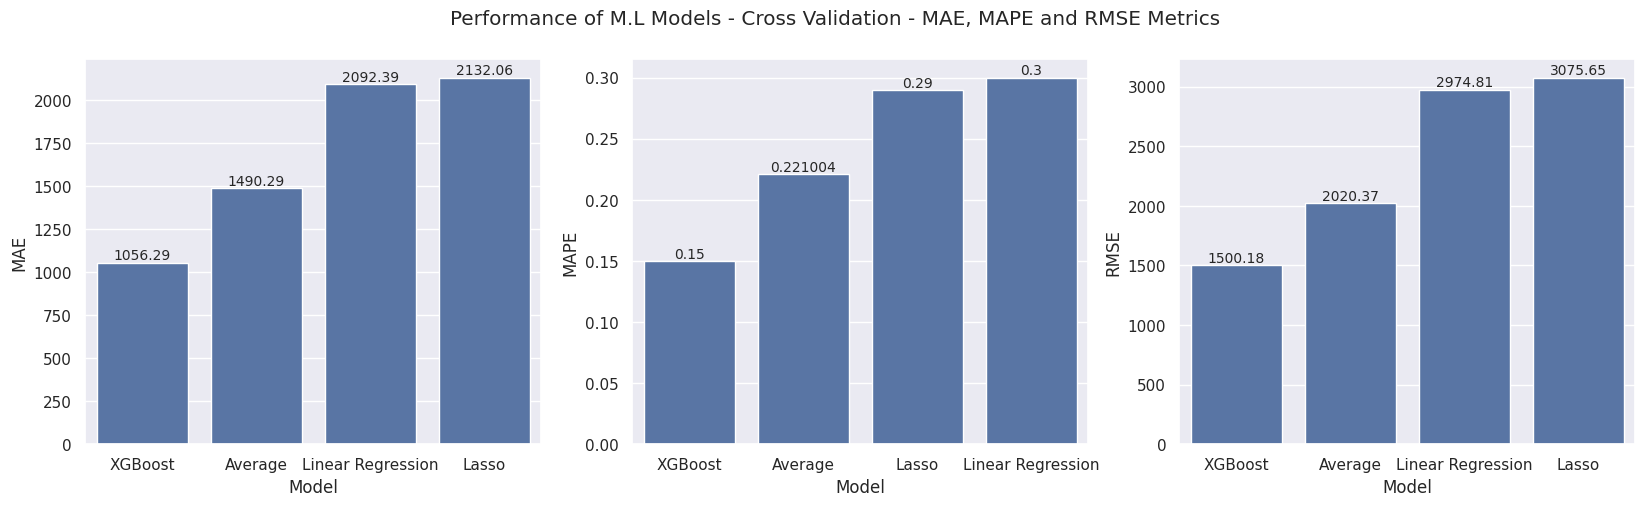

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Performance of M.L Models - Cross Validation - MAE, MAPE and RMSE Metrics')

aux1 = models_result_cv.sort_values('MAE')
ax=sns.barplot(data=aux1, x='Model', y='MAE', color='b', ax=axes[0]);
ax.bar_label(ax.containers[0], fontsize=10);

aux2 = models_result_cv.sort_values('MAPE')
ax=sns.barplot(data=aux2, x='Model', y='MAPE', color='b', ax=axes[1]);
ax.bar_label(ax.containers[0], fontsize=10);

aux3 = models_result_cv.sort_values('RMSE')
ax=sns.barplot(data=aux3, x='Model', y='RMSE', color='b', ax=axes[2]);
ax.bar_label(ax.containers[0], fontsize=10);


# 8.0 Hyperparameter Fine Tunning

## 8.1 Random Search

In [79]:
# create dict with names and values parameters
params = { 'n_estimators'     : [150, 170, 250, 300, 350],
           'eta'              : [0.1, 0.3],
           'max_depth'        : [3, 5, 9],
           'subsample'        : [0.1, 0.5, 0.7],
           'colsample_bytree' : [0.3, 0.5, 0.7],
           'min_child_weight' : [3, 8, 15]
          }

NUM_ITERATIONS = 10
xgb_model_result = pd.DataFrame()

for i in range( NUM_ITERATIONS ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in params.items() }
    print(f'Iteration n: { i+1 }. Parameters: { hp } ')

    # define model
    xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'],
                                ).fit( x_train, y_train )

    # create predictions
    yhat_xgb = xgb_model.predict( x_validation )

    # calculate performance
    result = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model, verbose=False )
    xgb_model_result = pd.concat( [xgb_model_result, result] )

xgb_model_result

Iteration n: 1. Parameters: {'n_estimators': 350, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 3} 


Iteration n: 2. Parameters: {'n_estimators': 150, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15} 
Iteration n: 3. Parameters: {'n_estimators': 300, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 15} 
Iteration n: 4. Parameters: {'n_estimators': 250, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8} 
Iteration n: 5. Parameters: {'n_estimators': 300, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15} 
Iteration n: 6. Parameters: {'n_estimators': 170, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8} 
Iteration n: 7. Parameters: {'n_estimators': 300, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8} 
Iteration n: 8. Parameters: {'n_estimators': 300, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_c

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.57 +/- 137.75,0.15 +/- 0.01,1478.1 +/- 191.42
0,XGBoost Regressor,1804.63 +/- 207.29,0.25 +/- 0.01,2593.25 +/- 277.97
0,XGBoost Regressor,1013.79 +/- 151.41,0.14 +/- 0.01,1438.31 +/- 208.88
0,XGBoost Regressor,1222.97 +/- 147.0,0.17 +/- 0.01,1741.5 +/- 223.03
0,XGBoost Regressor,1026.72 +/- 189.94,0.14 +/- 0.02,1456.71 +/- 261.58
0,XGBoost Regressor,1821.4 +/- 215.77,0.25 +/- 0.01,2614.88 +/- 297.97
0,XGBoost Regressor,858.52 +/- 145.59,0.12 +/- 0.01,1239.72 +/- 222.29
0,XGBoost Regressor,1678.68 +/- 182.8,0.23 +/- 0.01,2417.37 +/- 242.96
0,XGBoost Regressor,1264.51 +/- 139.32,0.17 +/- 0.01,1824.12 +/- 195.13
0,XGBoost Regressor,1484.6 +/- 177.93,0.2 +/- 0.01,2133.69 +/- 241.69


# 9.0 Final Model

## 9.1 Prepare train and test Datasets

In [5]:
# train dataset
X_train         = pd.read_csv( '../data/train_feat.csv',  low_memory= False )
X_train['date'] = pd.to_datetime( X_train['date'] )

x_train = X_train.copy()
x_train = x_train[final_features]
y_train = x_train['sales']
x_train = x_train.drop( columns=['date', 'sales'], axis=1 )

# test dataset
X_test         = pd.read_csv( '../data/test_feat.csv',  low_memory= False )
X_test['date'] = pd.to_datetime( X_test['date'] )

x_test = X_test.copy()
x_test = x_test[final_features]
y_test = x_test['sales']
x_test = x_test.drop( columns=['date', 'sales'], axis=1 )

print(f'Train Dataset Dimensions: Rows: { x_train.shape[0] }. Cols: {x_train.shape[1]} ' )
print(f'Test  Dataset Dimensions: Rows: { x_test.shape[0] }. Cols: {x_test.shape[1]} ' )

Train Dataset Dimensions: Rows: 804056. Cols: 18 
Test  Dataset Dimensions: Rows: 40282. Cols: 18 


## 9.2 Execute Average Model with Test DataSet

In [6]:
# create aux_df with database test + response variable (sales)
aux1          = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' :  'sales_predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_avg = aux1['sales_predictions']

# calculate performance with response variable "sales" on original scale 
avg_model_result = ml_error( 'Average', np.expm1( y_test ), np.expm1( yhat_avg ) )
avg_model_result

,Model Name,MAE,MAPE,RMSE
0,Average,1366.128351,0.207912,1854.263316


## 9.3 Execute Model with Test DataSet (new data) and Hyperparameters fine tunning

In [13]:
# BEST CROSS VALIDATION RESULT
#	XGBoost Regressor	843.91 +/- 135.2	0.12 +/- 0.01	1210.93 +/- 198.65
# Iteration n: 9. Parameters: {'n_estimators': 350, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 15} 


# define model
final_model = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=350,
                                    eta=0.1, 
                                    max_depth=9,  
                                    subsample=0.7,
                                    colsample_bytree=0.5,
                                    min_child_weight=15
                                  ).fit( x_train, y_train )

# create predictions
y_pred = final_model.predict( x_test )

# calculate performance
final_model_result = ml_error( 'XGBoost', np.expm1( y_test ), np.expm1( y_pred) )
final_model_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost,1003.092196,0.147244,1454.584701


## 9.4 Final Model vs Average Model

In [14]:
models_result = pd.concat( [avg_model_result, final_model_result] ).rename(columns={'Model Name' : 'Model' } ) 
models_result

,Model,MAE,MAPE,RMSE
0,Average,1366.128351,0.207912,1854.263316
0,XGBoost,1003.092196,0.147244,1454.584701


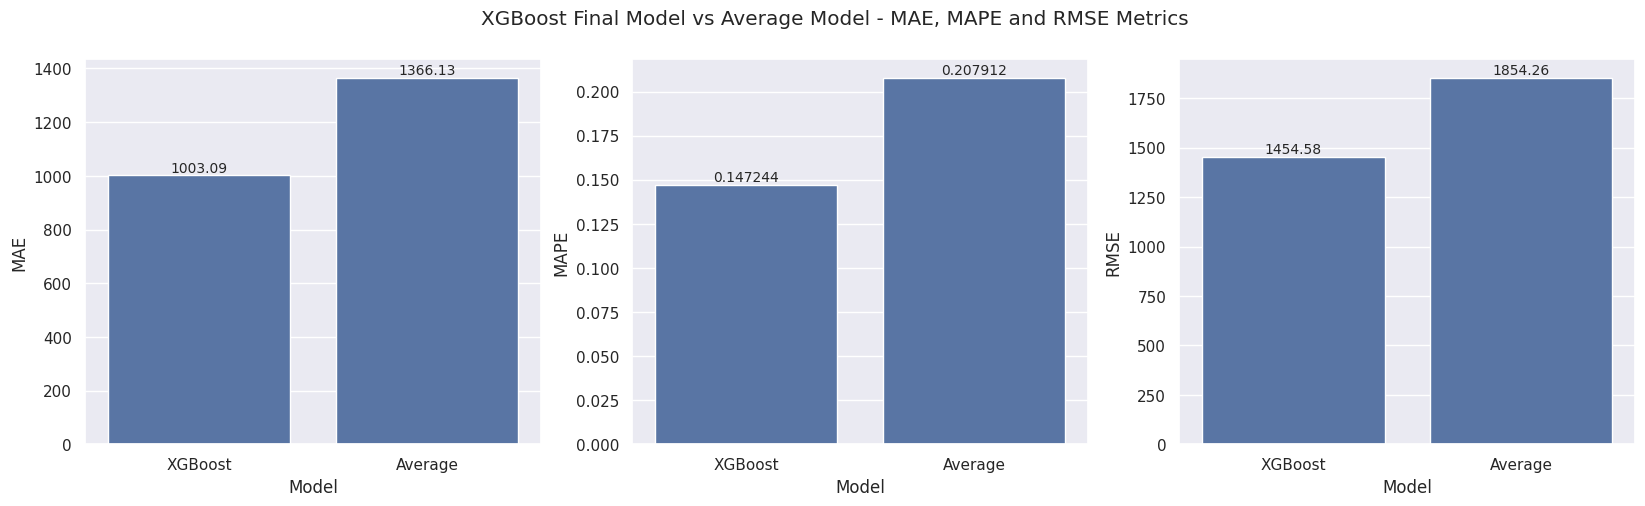

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('XGBoost Final Model vs Average Model - MAE, MAPE and RMSE Metrics')

aux1 = models_result.sort_values('MAE')
ax=sns.barplot(data=aux1, x='Model', y='MAE', color='b', ax=axes[0]);
ax.bar_label(ax.containers[0], fontsize=10);

aux2 = models_result.sort_values('MAPE')
ax=sns.barplot(data=aux2, x='Model', y='MAPE', color='b', ax=axes[1]);
ax.bar_label(ax.containers[0], fontsize=10);

aux3 = models_result.sort_values('RMSE')
ax=sns.barplot(data=aux3, x='Model', y='RMSE', color='b', ax=axes[2]);
ax.bar_label(ax.containers[0], fontsize=10);

## 9.5 Save Trained Model

In [16]:
# save Trained Model
pickle.dump( final_model, open( '../model/model_rossmann.pkl', 'wb' ) )

# 10.0 Business Report

In [83]:
df_predictions = get_model_prediction( '../data/test.csv' )
df_predictions.head()

,store,date,sales_predictions,sales,absolute_error
0,1,2015-07-31T00:00:00.000,5068.566895,5263,194.433105
1,2,2015-07-31T00:00:00.000,6562.854980,6064,498.854980
2,3,2015-07-31T00:00:00.000,8829.172852,8314,515.172852
3,4,2015-07-31T00:00:00.000,11710.250000,13995,2284.750000
4,5,2015-07-31T00:00:00.000,5357.667480,4822,535.667480


In [84]:
df_pred= df_predictions[['store', 'sales', 'absolute_error']].groupby('store').mean().reset_index()
df_pred['MAPE'] = round(df_pred['absolute_error'] / df_pred['sales'] * 100, 2)

#df_best =  df_pred[ df_pred['MAPE'] < 25.0]
#df_worst = df_pred[ df_pred['MAPE'] >= 25.0]

#df_store_raw = rename_columns( df_store_raw )

#df_best =  pd.merge( df_best,  df_store_raw, how='inner', on='store' )
#df_worst = pd.merge( df_worst, df_store_raw, how='inner', on='store' )

    

In [85]:
df_predictions['absolute_error'].mean() / df_predictions['sales'] .mean()

0.1607332131524591

In [ ]:
rs1 = RobustScaler()

z = rs.fit_transform